# Objective

To build ML models to predict churn. The predictive model will solve the following purposes:

1. It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

2. It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

3. Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

4. Recommend strategies to manage customer churn based on your observations

In [ ]:
!pip install fancyimpute

In [ ]:
!pip show fancyimpute

In [ ]:
pip install --upgrade fancyimpute

In [ ]:
# import sklearn

# # Print the version of scikit-learn
# print(sklearn.__version__)

# Check if IterativeImputer is available
try:
    from sklearn.impute import IterativeImputer
    print("IterativeImputer is available.")
except ImportError:
    print("IterativeImputer is not available.")

In [ ]:
!pip install --upgrade scikit-learn

# Imports

In [1]:
from fancyimpute import IterativeImputer

(CVXPY) Aug 08 09:59:52 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Aug 08 09:59:52 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Aug 08 09:59:52 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: The specified module could not be found.')


In [2]:
from sklearn.impute import IterativeImputer

In [3]:
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importing Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# For Imputation
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV


# Custom Methods

## Correlation Heatmap

In [294]:
def get_corr_heatmap(original_train_data, threshold=0.80, fig_size = (20,16)):
    
    figure = plt.subplots(figsize=fig_size)
    
    # Calculating the correlation b/w the given set of features
    corr_matrix = original_train_data.corr()
    
    # Selecting correlation values greater than the threshold
    high_corr_matrix = corr_matrix[abs(corr_matrix) > threshold]
    
    # Plotting the heatmap of the correlation matrix
    return sns.heatmap(high_corr_matrix, cmap="coolwarm", annot = True, fmt=".2f")

## Metric Calculator

In [6]:
def get_evaluation_metrics(database, actual_y_column_name, predicted_y_column_name, Print=True):
    
    # Confusion matrix 
    confusion_matrix_table = metrics.confusion_matrix(database[actual_y_column_name], database[predicted_y_column_name])
    if Print:
        print('Confusion Matrix: \n', confusion_matrix_table)
    #confusion_matrix = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted)
    
    # Precision Score
    precision = np.round(precision_score(database[actual_y_column_name], database[predicted_y_column_name]),2)
    if Print:
        print('Precision Score: ', precision)
    #precision_score = precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)
    
    # Recall Score
    recall = np.round(recall_score(database[actual_y_column_name], database[predicted_y_column_name]),2)
    if Print:
        print('Recall Score: ', recall)
    #recall_score = recall_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)
    
    # Extract the values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_table.ravel()

    # Calculate specificity
    specificity = np.round(TN / (TN + FP),2)
    if Print:
        print('Specificity: ', specificity)
    
    # False Negative
    FN_perc = np.round((FN/len(database))*100,2)
    if Print:
        print(f'False Negative %: {FN_perc} ({FN})')
    
    # Accuracy Score
    accuracy = np.round(metrics.accuracy_score(database[actual_y_column_name], database[predicted_y_column_name]),2)
    if Print:
        print('Accuracy: ', accuracy)
        
    # AUC Score        
    auc_score = np.round(metrics.roc_auc_score(database[actual_y_column_name], database[predicted_y_column_name]),2)
    if Print:
        print('Auc Score: ', auc_score)
    
    return confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score

## Prediction Table

In [7]:
def get_prediction_table( actual_y_df,  pred_y_prob_df, cut_off=0.5, Print=True):
    prediction_table = pd.DataFrame()
    prediction_table['Actual_y'] = actual_y_df
    prediction_table['Pred_y_prob'] = pred_y_prob_df
    prediction_table['Predicted'] = prediction_table['Pred_y_prob'].map(lambda x: 1 if x > cut_off else 0)
    if Print:
        print('Shape of Prediction Table: ', prediction_table.shape)
        print('Glance of the Prediction Table: \n',prediction_table.head())
    return prediction_table

## Dummy Variables Creator

In [8]:
# Function to create dummy variables
def create_dummies(database, column_name):
    
    # Creating dummy variables for the categorical variable
    dummy_df = pd.get_dummies(database[column_name], prefix=column_name , drop_first = True)
    
    # Concatenating dummy dataframe with the original dataframe
    database = pd.concat([database, dummy_df], axis=1)
    
    # Dropping categorical column for which dummy variables have been created
    database = database.drop(column_name, axis=1)
    
    return database

## Capping Outliers

In [9]:
# Capping outliers in all numeric variables with k-sigma technique
def cap_outliers(data_col, k=2):
    upper_limit = data_col.mean() + k*data_col.std()
    lower_limit = data_col.mean() - k*data_col.std()
    data_col[data_col<lower_limit] = lower_limit
    data_col[data_col>upper_limit] = upper_limit
    return data_col

## Quantify Outliers

In [10]:
def quantify_outliers(database, cols_to_be_considered):
    
    outliers_df = pd.DataFrame(columns=['Total', '%'])
    data_size = len(database)
    
    # Data with concerned columns
    data_to_consider = database[cols_to_be_considered]
    
    q1 = data_to_consider.quantile(0.25)
    q3 = data_to_consider.quantile(0.75)
    IQR = q3 - q1
    
    lower_threshold = q1 - 1.5 * IQR
    upper_threshold = q3 + 1.5 * IQR
    
    # Extracting outliers
    outliers = (data_to_consider < lower_threshold) | (data_to_consider > upper_threshold)
    
    col_wise_sum = outliers.sum()
    
    col_wise_perc = (col_wise_sum/data_size)*100
    
    outliers_df['Total'] = col_wise_sum
    outliers_df['%'] = col_wise_perc    
    sorted_outliers_df = outliers_df.sort_values(by='Total', ascending=False)
    
    return sorted_outliers_df

## Extracting Total Recharge Amount (Data + Call)

In [73]:
def get_total_rech_col(database, total_rech_data, av_rech_amt_data, total_rech_amt_call):
    total_data_rech_amt = database[total_rech_data] * database[av_rech_amt_data]
    total_rech_data_call_col = total_data_rech_amt + database[total_rech_amt_call]
    return total_rech_data_call_col

# Data Understanding

## Unseen Data

In [11]:
# Test Data
original_unseen_data = pd.read_csv('test.csv')
original_unseen_data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

In [12]:
original_unseen_data.shape

(30000, 171)

In [13]:
# Creating a working copy
unseen_data = copy.deepcopy(original_unseen_data)
unseen_data.shape

(30000, 171)

## Complete Data

In [14]:
# Training Data
original_data = pd.read_csv('train.csv')
original_data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [15]:
original_data.shape

(69999, 172)

In [16]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [17]:
original_data.describe(include='all')

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   69999.000000    69999.0         69297.0         69297.0   
unique           NaN        NaN             NaN             NaN   
top              NaN        NaN             NaN             NaN   
freq             NaN        NaN             NaN             NaN   
mean    34999.000000      109.0             0.0             0.0   
std     20207.115084        0.0             0.0             0.0   
min         0.000000      109.0             0.0             0.0   
25%     17499.500000      109.0             0.0             0.0   
50%     34999.000000      109.0             0.0             0.0   
75%     52498.500000      109.0             0.0             0.0   
max     69998.000000      109.0             0.0             0.0   

        loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
count          69297.0                69999                69600   
unique             NaN                    1                    1   
top                NaN            6/30/2014            7/31/2014   
freq               NaN                69999                69600   
mean               0.0                  NaN                  NaN   
std                0.0                  NaN                  NaN   
min                0.0                  NaN                  NaN   
25%                0.0                  NaN                  NaN   
50%                0.0                  NaN                  NaN   
75%                0.0                  NaN                  NaN   
max                0.0                  NaN                  NaN   

       last_date_of_month_8        arpu_6        arpu_7  ...   sachet_3g_7  \
count                 69266  69999.000000  69999.000000  ...  69999.000000   
unique                    1           NaN           NaN  ...           NaN   
top               8/31/2014           NaN           NaN  ...           NaN   
freq                  69266           NaN           NaN  ...           NaN   
mean                    NaN    283.134365    278.185912  ...      0.081444   
std                     NaN    334.213918    344.366927  ...      0.634547   
min                     NaN  -2258.709000  -1289.715000  ...      0.000000   
25%                     NaN     93.581000     86.714000  ...      0.000000   
50%                     NaN    197.484000    191.588000  ...      0.000000   
75%                     NaN    370.791000    365.369500  ...      0.000000   
max                     NaN  27731.088000  35145.834000  ...     33.000000   

         sachet_3g_8     fb_user_6     fb_user_7     fb_user_8           aon  \
count   69999.000000  17568.000000  17865.000000  18417.000000  69999.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.085487      0.916325      0.909544      0.890319   1220.639709   
std         0.680035      0.276907      0.286842      0.312501    952.426321   
min         0.000000      0.000000      0.000000      0.000000    180.000000   
25%         0.000000      1.000000      1.000000      1.000000    468.000000   
50%         0.000000      1.000000      1.000000      1.000000    868.000000   
75%         0.000000      1.000000      1.000000      1.000000   1813.000000   
max        41.000000      1.000000      1.000000      1.000000   4337.000000   

          aug_vbc_3g    jul_vbc_3g   jun_vbc_3g  churn_probability  
count   69999.000000  69999.000000  69999.00000       69999.000000  
unique           NaN           NaN          NaN                NaN  
top              NaN           NaN          NaN                NaN  
freq             NaN           NaN          NaN                NaN  
mean       68.108597     65.935830     60.07674           0.101887  
std       269.328659    267.899034    257.22681           0.302502  
min         0.0

In [18]:
data_columns = list(original_data.columns)
data_columns

['id',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 

In [19]:
original_data['churn_probability'].value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

In [20]:
(original_data['churn_probability'].value_counts()/len(original_data))*100

0    89.811283
1    10.188717
Name: churn_probability, dtype: float64

In [21]:
# Creating a working copy
data = copy.deepcopy(original_data)
data.shape

(69999, 172)

## Findings

1. We have 2 separate dataset - one for training & testing i.e. 'train.csv' & one for making prediction (unseen data - type of data you can aspect after deployment of your model) like we do in real life  i.e. 'test.csv'
2. 'test.csv' dataset have 30,000 rows & 171 columns
3. 'train.csv' dataset have 69,999 rows & 172 columns
4. Both the dataset have save columns except 'train.csv' dataset that have 1 column extra i.e. 'churn_probability' which is our target variable
5. We have a very high class imbalance in data i.e.
    * No. of customers who have not churned ('0' - Negative Class) = 62,867/69,999 = 90% (Approx)
    * No. of customers who have churned ('1' - Positive Class)     =  7,132/69,999 = 10% (Approx)
6. There are 3 different data types:
    * float64 - 135 columns
    * int64   -  28 columns
    * object  -   9 columns

# Creating cols list by type of cols

In [22]:
# Set the display option to show all rows of the DataFrame
pd.set_option('display.max_rows', None)

In [23]:
null_value_counter_list = print((data.isnull().sum()/len(data))*100)
null_value_counter_list

id                           0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.002871
std_og_t2o_mou               1.002871
loc_ic_t2o_mou               1.002871
last_date_of_month_6         0.000000
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_m

In [24]:
# Reset the display option to its default value
pd.reset_option('display.max_rows')

In [25]:
id_cols = ['id', 'circle_id']

date_cols = [
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

cat_cols = [
    
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

recharge_cols = [
    
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
    
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',

 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
    
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',

 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',

 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

target_variable = ['churn_probability']

In [26]:
all_except_num_cols = id_cols + date_cols + cat_cols + target_variable
all_except_num_cols

['id',
 'circle_id',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn_probability']

In [27]:
num_cols = list(set(list(data.columns)) - set(all_except_num_cols))
num_cols

['og_others_7',
 'sachet_2g_6',
 'loc_ic_mou_6',
 'og_others_6',
 'total_og_mou_6',
 'roam_og_mou_8',
 'vol_3g_mb_8',
 'loc_og_mou_6',
 'total_rech_amt_6',
 'roam_og_mou_7',
 'isd_ic_mou_6',
 'onnet_mou_8',
 'arpu_2g_7',
 'last_day_rch_amt_7',
 'std_og_t2f_mou_7',
 'std_ic_t2f_mou_6',
 'max_rech_amt_7',
 'spl_og_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_og_t2m_mou_7',
 'std_ic_mou_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_3g_7',
 'std_og_t2t_mou_7',
 'total_rech_data_8',
 'std_og_t2m_mou_8',
 'count_rech_2g_8',
 'monthly_2g_7',
 'loc_ic_t2m_mou_6',
 'monthly_2g_8',
 'loc_og_mou_7',
 'ic_others_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'onnet_mou_7',
 'monthly_3g_8',
 'max_rech_amt_6',
 'isd_og_mou_6',
 'total_rech_num_8',
 'sachet_3g_7',
 'isd_ic_mou_7',
 'loc_og_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'roam_ic_mou_6',
 'loc_og_t2m_mou_8',
 'std_og_t2o_mou',
 'av_rech_amt_data_8',
 'onnet_mou_6',
 'vol_2g_mb_8',
 'std_ic_t2t_mou_7',
 'std_og_t2c_mou_6',
 'sachet_3g_6',
 'loc_og_t2c_m

In [28]:
len(num_cols)

154

# Data Cleaning

## Checking duplicates

In [29]:
no_of_duplicates = data.duplicated().sum()
no_of_duplicates

0

## Dealing with Null Values

In [30]:
perc_null_values = (((data.isnull().sum())/(len(data)))*100).sort_values(ascending = False)
total_null_values = data.isnull().sum().sort_values(ascending=False)
null_values_df = pd.concat([total_null_values, perc_null_values], axis=1, keys=['Total', '%'])
null_values_df

Total          %
arpu_3g_6                 52431  74.902499
count_rech_2g_6           52431  74.902499
night_pck_user_6          52431  74.902499
arpu_2g_6                 52431  74.902499
date_of_last_rech_data_6  52431  74.902499
...                         ...        ...
last_day_rch_amt_8            0   0.000000
vol_2g_mb_6                   0   0.000000
vol_2g_mb_7                   0   0.000000
vol_2g_mb_8                   0   0.000000
churn_probability             0   0.000000

[172 rows x 2 columns]

### Analysing Recharge Cols

In [31]:
date_and_recharge_cols = recharge_cols + date_cols
date_and_recharge_cols

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [32]:
# Selecting cols which have '6' in the col name
selected_cols_with_6 = [col for col in date_and_recharge_cols if '6' in col]

# calculating the no. of null values in the above selected cols
selected_cols_null_counter = data[selected_cols_with_6].isnull().sum()

# Selecting the cols which have atleast 1 null value
selected_cols_with_6_and_null_values = selected_cols_null_counter[selected_cols_null_counter!=0]
selected_cols_with_6_and_null_values

total_rech_data_6           52431
max_rech_data_6             52431
count_rech_2g_6             52431
count_rech_3g_6             52431
av_rech_amt_data_6          52431
date_of_last_rech_6          1101
date_of_last_rech_data_6    52431
dtype: int64

In [33]:
# dropping 'date_of_last_rech_6' for analysis as it doesn't have similar no. of null values.
selected_cols_with_6_and_null_values.drop('date_of_last_rech_6', inplace=True)

# Creating a dataframe of the above selected columns
data_to_inspect = data[selected_cols_with_6_and_null_values.index]

# Extracting only those rows of the dataframe where 'date_of_last_rech_data_6' column has null value
data_to_inspect[data_to_inspect['date_of_last_rech_data_6'].isnull()]

total_rech_data_6  max_rech_data_6  count_rech_2g_6  count_rech_3g_6  \
0                    NaN              NaN              NaN              NaN   
1                    NaN              NaN              NaN              NaN   
2                    NaN              NaN              NaN              NaN   
3                    NaN              NaN              NaN              NaN   
5                    NaN              NaN              NaN              NaN   
...                  ...              ...              ...              ...   
69991                NaN              NaN              NaN              NaN   
69992                NaN              NaN              NaN              NaN   
69994                NaN              NaN              NaN              NaN   
69995                NaN              NaN              NaN              NaN   
69996                NaN              NaN              NaN              NaN   

       av_rech_amt_data_6 date_of_last_rech_data_6  
0                     NaN                      NaN  
1                     NaN                      NaN  
2                     NaN                      NaN  
3                     NaN                      NaN  
5                     NaN                      NaN  
...                   ...                      ...  
69991                 NaN                      NaN  
69992                 NaN                      NaN  
69994                 NaN                      NaN  
69995                 NaN                      NaN  
69996                 NaN                      NaN  

[52431 rows x 6 columns]

From the above data, we can notice that whenever we don't have any value in the date column, the data in other recharge cols is missing. This means that the data is not missing rather the customer hasn't made any recharge in that month.

In [34]:
data[selected_cols_with_6_and_null_values.index].describe(include='all')

total_rech_data_6  max_rech_data_6  count_rech_2g_6  count_rech_3g_6  \
count        17568.000000     17568.000000     17568.000000     17568.000000   
unique                NaN              NaN              NaN              NaN   
top                   NaN              NaN              NaN              NaN   
freq                  NaN              NaN              NaN              NaN   
mean             2.467612       126.500000         1.865323         0.602288   
std              2.794610       109.352573         2.566377         1.279297   
min              1.000000         1.000000         0.000000         0.000000   
25%              1.000000        25.000000         1.000000         0.000000   
50%              1.000000       145.000000         1.000000         0.000000   
75%              3.000000       177.000000         2.000000         1.000000   
max             61.000000      1555.000000        42.000000        29.000000   

        av_rech_amt_data_6 date_of_last_rech_data_6  
count         17568.000000                    17568  
unique                 NaN                       30  
top                    NaN                6/30/2014  
freq                   NaN                     1317  
mean            192.831096                      NaN  
std             190.623115                      NaN  
min               1.000000                      NaN  
25%              82.000000                      NaN  
50%             154.000000                      NaN  
75%             252.000000                      NaN  
max            5920.000000                      NaN

Now, the minimum value is '1' in the recharge cols ('total_rech_data_6', 'max_rech_data_6' & 'av_rech_amt_data_6') when the customer has made recharge which means that we can impute '0' when customer hasn't made any recharge.

Let's verify the similar trend in rest of the months.

In [35]:
# Selecting cols which have '7' in the col name
selected_cols_with_7 = [col for col in date_and_recharge_cols if '7' in col]

# calculating the no. of null values in the above selected cols
selected_cols_null_counter_7 = data[selected_cols_with_7].isnull().sum()

# Selecting the cols which have atleast 1 null value
selected_cols_with_7_and_null_values = selected_cols_null_counter_7[selected_cols_null_counter_7!=0]
selected_cols_with_7_and_null_values

total_rech_data_7           52134
max_rech_data_7             52134
count_rech_2g_7             52134
count_rech_3g_7             52134
av_rech_amt_data_7          52134
last_date_of_month_7          399
date_of_last_rech_7          1234
date_of_last_rech_data_7    52134
dtype: int64

In [36]:
# Selecting cols which have '6' in the col name
selected_cols_with_8 = [col for col in date_and_recharge_cols if '8' in col]

# calculating the no. of null values in the above selected cols
selected_cols_null_counter_8 = data[selected_cols_with_8].isnull().sum()

# Selecting the cols which have atleast 1 null value
selected_cols_with_8_and_null_values = selected_cols_null_counter_8[selected_cols_null_counter_8!=0]
selected_cols_with_8_and_null_values

total_rech_data_8           51582
max_rech_data_8             51582
count_rech_2g_8             51582
count_rech_3g_8             51582
av_rech_amt_data_8          51582
last_date_of_month_8          733
date_of_last_rech_8          2461
date_of_last_rech_data_8    51582
dtype: int64

Since, we have the same trend, therefore, we can impute missing values with '0' in these as well

In [37]:
cols_impute_with_zero = ['total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6',
                         'total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7',
                         'total_rech_data_8', 'max_rech_data_8', 'av_rech_amt_data_8']
cols_impute_with_zero

['total_rech_data_6',
 'max_rech_data_6',
 'av_rech_amt_data_6',
 'total_rech_data_7',
 'max_rech_data_7',
 'av_rech_amt_data_7',
 'total_rech_data_8',
 'max_rech_data_8',
 'av_rech_amt_data_8']

#### '0' (Zero) Imputation

In [38]:
data[cols_impute_with_zero].isnull().sum()

total_rech_data_6     52431
max_rech_data_6       52431
av_rech_amt_data_6    52431
total_rech_data_7     52134
max_rech_data_7       52134
av_rech_amt_data_7    52134
total_rech_data_8     51582
max_rech_data_8       51582
av_rech_amt_data_8    51582
dtype: int64

In [39]:
data[cols_impute_with_zero] = data[cols_impute_with_zero].fillna(0)

In [40]:
data[cols_impute_with_zero].isnull().sum()

total_rech_data_6     0
max_rech_data_6       0
av_rech_amt_data_6    0
total_rech_data_7     0
max_rech_data_7       0
av_rech_amt_data_7    0
total_rech_data_8     0
max_rech_data_8       0
av_rech_amt_data_8    0
dtype: int64

### Analysing categorical columns

In [41]:
cat_cols

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [42]:
data[cat_cols]

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  \
0                   NaN               NaN               NaN        NaN   
1                   NaN               0.0               NaN        NaN   
2                   NaN               NaN               NaN        NaN   
3                   NaN               NaN               NaN        NaN   
4                   0.0               0.0               0.0        1.0   
...                 ...               ...               ...        ...   
69994               NaN               0.0               0.0        NaN   
69995               NaN               NaN               NaN        NaN   
69996               NaN               NaN               NaN        NaN   
69997               0.0               0.0               0.0        1.0   
69998               0.0               NaN               0.0        1.0   

       fb_user_7  fb_user_8  
0            NaN        NaN  
1            1.0        NaN  
2            NaN        NaN  
3            NaN        NaN  
4            1.0        1.0  
...          ...        ...  
69994        1.0        1.0  
69995        NaN        NaN  
69996        NaN        NaN  
69997        1.0        1.0  
69998        NaN        1.0  

[69999 rows x 6 columns]

In [43]:
(data[cat_cols].isnull().sum()/len(data))*100

night_pck_user_6    74.902499
night_pck_user_7    74.478207
night_pck_user_8    73.689624
fb_user_6           74.902499
fb_user_7           74.478207
fb_user_8           73.689624
dtype: float64

In [44]:
# Let's check the values one-by-one
for col in cat_cols:
    print(f'---- Value Count of {col} ----')
    print(data[col].value_counts())
    print()

---- Value Count of night_pck_user_6 ----
0.0    17124
1.0      444
Name: night_pck_user_6, dtype: int64

---- Value Count of night_pck_user_7 ----
0.0    17435
1.0      430
Name: night_pck_user_7, dtype: int64

---- Value Count of night_pck_user_8 ----
0.0    18030
1.0      387
Name: night_pck_user_8, dtype: int64

---- Value Count of fb_user_6 ----
1.0    16098
0.0     1470
Name: fb_user_6, dtype: int64

---- Value Count of fb_user_7 ----
1.0    16249
0.0     1616
Name: fb_user_7, dtype: int64

---- Value Count of fb_user_8 ----
1.0    16397
0.0     2020
Name: fb_user_8, dtype: int64



Since, there are only two types of values '0' & '1'. Therefore, we can mark the missing values as a 3rd category i.e. '-1'. This way we don't need to drop the columns and if there is some hidden pattern, then, we 'll be able to identify that using our new category.

#### '-1' Imputation

In [45]:
data[cat_cols] = data[cat_cols].fillna(-1)

In [46]:
(data[cat_cols].isnull().sum()/len(data))*100

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64

### Removing Unnecessary Cols

In [47]:
data.shape

(69999, 172)

In [48]:
data[date_cols]

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0                6/30/2014            7/31/2014            8/31/2014   
1                6/30/2014            7/31/2014            8/31/2014   
2                6/30/2014            7/31/2014            8/31/2014   
3                6/30/2014            7/31/2014            8/31/2014   
4                6/30/2014            7/31/2014            8/31/2014   
...                    ...                  ...                  ...   
69994            6/30/2014            7/31/2014            8/31/2014   
69995            6/30/2014            7/31/2014            8/31/2014   
69996            6/30/2014            7/31/2014            8/31/2014   
69997            6/30/2014            7/31/2014            8/31/2014   
69998            6/30/2014            7/31/2014            8/31/2014   

      date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0               6/22/2014           7/10/2014           8/24/2014   
1               6/12/2014           7/10/2014           8/26/2014   
2               6/11/2014           7/22/2014           8/24/2014   
3               6/15/2014           7/21/2014           8/25/2014   
4               6/25/2014           7/26/2014           8/30/2014   
...                   ...                 ...                 ...   
69994           6/18/2014           7/31/2014           8/31/2014   
69995           6/28/2014           7/31/2014           8/27/2014   
69996           6/25/2014           7/30/2014           8/29/2014   
69997           6/29/2014           7/19/2014           8/26/2014   
69998           6/19/2014           7/27/2014           8/25/2014   

      date_of_last_rech_data_6 date_of_last_rech_data_7  \
0                          NaN                      NaN   
1                          NaN                 7/8/2014   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                    6/25/2014                7/23/2014   
...                        ...                      ...   
69994                      NaN                7/31/2014   
69995                      NaN                      NaN   
69996                      NaN                      NaN   
69997                6/17/2014                7/13/2014   
69998                6/19/2014                      NaN   

      date_of_last_rech_data_8  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                    8/20/2014  
...                        ...  
69994                8/21/2014  
69995                      NaN  
69996                      NaN  
69997                8/14/2014  
69998                 8/8/2014  

[69999 rows x 9 columns]

In [49]:
data[id_cols]

id  circle_id
0          0        109
1          1        109
2          2        109
3          3        109
4          4        109
...      ...        ...
69994  69994        109
69995  69995        109
69996  69996        109
69997  69997        109
69998  69998        109

[69999 rows x 2 columns]

All the columns in 'id_cols' and 'date_cols' are of no use now. Therefore, we 'll drop them

In [50]:
unnecessary_cols = date_cols + id_cols
unnecessary_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'id',
 'circle_id']

In [51]:
data.drop(unnecessary_cols, axis=1, inplace=True)
data.shape

(69999, 161)

### Dropping Cols with > 70% null values

In [52]:
perc_null_values = (((data.isnull().sum())/(len(data)))*100).sort_values(ascending = False)
total_null_values = data.isnull().sum().sort_values(ascending=False)
null_values_df = pd.concat([total_null_values, perc_null_values], axis=1, keys=['Total', '%'])
more_than_70_per_null_values = null_values_df[null_values_df['%']>70]
more_than_70_per_null_values

Total          %
count_rech_3g_6  52431  74.902499
arpu_2g_6        52431  74.902499
count_rech_2g_6  52431  74.902499
arpu_3g_6        52431  74.902499
arpu_2g_7        52134  74.478207
count_rech_2g_7  52134  74.478207
count_rech_3g_7  52134  74.478207
arpu_3g_7        52134  74.478207
arpu_3g_8        51582  73.689624
count_rech_2g_8  51582  73.689624
count_rech_3g_8  51582  73.689624
arpu_2g_8        51582  73.689624

In [53]:
len(more_than_70_per_null_values)

12

In [54]:
data.drop(list(more_than_70_per_null_values.index), axis=1, inplace=True)
data.shape

(69999, 149)

### Cols with < 10% null values

In [55]:
perc_null_values = (((data.isnull().sum())/(len(data)))*100).sort_values(ascending = False)
total_null_values = data.isnull().sum().sort_values(ascending=False)
null_values_df = pd.concat([total_null_values, perc_null_values], axis=1, keys=['Total', '%'])
atleast_1_null_value = null_values_df[null_values_df['Total'] > 0]
less_than_10_per_null_values = atleast_1_null_value[atleast_1_null_value['%']<10]
less_than_10_per_null_values

Total         %
std_ic_t2t_mou_8   3703  5.290076
spl_og_mou_8       3703  5.290076
loc_og_t2c_mou_8   3703  5.290076
loc_og_mou_8       3703  5.290076
std_og_t2t_mou_8   3703  5.290076
...                 ...       ...
loc_ic_t2t_mou_7   2687  3.838626
std_og_t2c_mou_7   2687  3.838626
loc_og_t2o_mou      702  1.002871
std_og_t2o_mou      702  1.002871
loc_ic_t2o_mou      702  1.002871

[90 rows x 2 columns]

In [56]:
len(less_than_10_per_null_values.index)

90

In [57]:
data.shape

(69999, 149)

#### Trying Removing records with null values

In [58]:
temp = copy.deepcopy(data)
temp.shape

(69999, 149)

In [59]:
temp.dropna(subset=less_than_10_per_null_values.index, inplace=True)
temp.shape

(63842, 149)

We have lost almost 9% data (i.e. approx 6,000 records) which is not good. Therefore, let's try MICE imputation as this 'll not impact our data much.

#### MICE Imputation

In [60]:
temp2 = copy.deepcopy(data)
temp2.shape

(69999, 149)

In [61]:
# calling the  MICE class
mice_imputer = IterativeImputer(random_state=10)
# imputing the missing value with mice imputer
imputed_data = mice_imputer.fit_transform(temp2[less_than_10_per_null_values.index])
imputed_data.shape

(69999, 90)

In [62]:
# convert imputed numpy array to pandas dataframe
imputed_data_df = pd.DataFrame(imputed_data, columns=less_than_10_per_null_values.index)
imputed_data_df.head()

std_ic_t2t_mou_8  spl_og_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
0              0.21          0.00              0.00          2.61   
1              0.00         31.66             29.79          0.00   
2              0.00          0.00              0.00          0.00   
3              0.00         25.61              8.03         23.63   
4              0.00          0.00              0.00         15.76   

   std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  std_og_t2c_mou_8  \
0              1.01               0.0               0.0               0.0   
1              0.00               0.0               0.0               0.0   
2              0.00               0.0               0.0               0.0   
3              0.00               4.6               0.0               0.0   
4              0.00               0.0               0.0               0.0   

   std_og_mou_8  isd_og_mou_8  ...  isd_og_mou_7  spl_og_mou_7  og_others_7  \
0          1.01           0.0  ...           0.0          0.63          0.0   
1          0.00           0.0  ...           0.0         30.73          0.0   
2          0.00           0.0  ...           0.0          1.38          0.0   
3          4.60           0.0  ...           0.0          9.13          0.0   
4          0.00           0.0  ...           0.0         17.00          0.0   

   offnet_mou_7  isd_ic_mou_7  loc_ic_t2t_mou_7  std_og_t2c_mou_7  \
0         96.68           0.0              3.68               0.0   
1         25.99           0.0             19.09               0.0   
2         82.05           0.0              6.16               0.0   
3         78.48           0.0              4.84               0.0   
4         38.11           0.0              1.39               0.0   

   loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  
0             0.0             0.0             0.0  
1             0.0             0.0             0.0  
2             0.0             0.0             0.0  
3             0.0             0.0             0.0  
4             0.0             0.0             0.0  

[5 rows x 90 columns]

In [63]:
temp2.drop(less_than_10_per_null_values.index, axis=1, inplace=True)
temp2.shape

(69999, 59)

In [64]:
final_data_after_imputation = pd.concat([temp2, imputed_data_df],axis=1)
final_data_after_imputation

arpu_6   arpu_7   arpu_8  total_og_mou_6  total_og_mou_7  \
0       31.277   87.009    7.527           81.21          221.68   
1        0.000  122.787   42.953            0.00           30.73   
2       60.806  103.176    0.000           56.49           99.36   
3      156.362  205.260  111.095           76.03           95.98   
4      240.708  128.191  101.565           63.26           42.94   
...        ...      ...      ...             ...             ...   
69994   15.760  410.924  329.136            0.00          496.68   
69995  160.083  289.129  265.772          166.21          292.74   
69996  372.088  258.374  279.782          412.68          296.39   
69997  238.575  245.414  145.062           39.78           24.33   
69998  168.269   42.815  167.961            0.00            0.00   

       total_og_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0                3.63           11.84           53.04           40.56   
1               31.66            3.44           39.44           25.04   
2                0.00          124.29           33.83           36.64   
3               53.84           95.11           50.18           83.84   
4               15.76           21.54            9.36           28.31   
...               ...             ...             ...             ...   
69994          392.58            0.00          221.99          269.56   
69995          280.69           80.24          112.43          136.01   
69996          342.29          542.18          416.58          414.54   
69997           19.28           18.83           16.24           17.76   
69998            0.00            8.13           65.09           33.58   

       total_rech_num_6  ...  isd_og_mou_7  spl_og_mou_7  og_others_7  \
0                     3  ...           0.0          0.63          0.0   
1                     3  ...           0.0         30.73          0.0   
2                     2  ...           0.0          1.38          0.0   
3                     2  ...           0.0          9.13          0.0   
4                    13  ...           0.0         17.00          0.0   
...                 ...  ...           ...           ...          ...   
69994                 1  ...           0.0         14.05          0.0   
69995                 5  ...           0.0          4.01          0.0   
69996                 3  ...           0.0          4.10          0.0   
69997                 5  ...           0.0          0.00          0.0   
69998                 2  ...           0.0          0.00          0.0   

       offnet_mou_7  isd_ic_mou_7  loc_ic_t2t_mou_7  std_og_t2c_mou_7  \
0             96.68           0.0              3.68               0.0   
1             25.99           0.0             19.09               0.0   
2             82.05           0.0              6.16               0.0   
3             78.48           0.0              4.84               0.0   
4             38.11           0.0              1.39               0.0   
...             ...           ...               ...               ...   
69994        488.46           0.0             26.59               0.0   
69995         96.28           0.0             28.48               0.0   
69996        227.94           0.0             30.29               0.0   
69997         16.68           0.0              3.64               0.0   
69998          0.00           0.0              4.31               0.0   

       loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  
0                 0.0             0.0             0.0  
1                 0.0             0.0             0.0  
2                 0.0             0.0             0.0  
3                 0.0             0.0             0.0  
4                 0.0             0.0             0.0  
...               ...             ...             ...  
69994             0.0             0.0             0.0  
69995             0.0             0.0             0.0  
69996             0.0             0.0             0.0  


In [65]:
perc_null_values = (((final_data_after_imputation.isnull().sum())/(len(final_data_after_imputation)))*100).sort_values(ascending = False)
total_null_values = final_data_after_imputation.isnull().sum().sort_values(ascending=False)
null_values_df = pd.concat([total_null_values, perc_null_values], axis=1, keys=['Total', '%'])
null_values_df

Total    %
arpu_6                0  0.0
std_ic_t2t_mou_6      0  0.0
offnet_mou_6          0  0.0
loc_ic_t2t_mou_6      0  0.0
loc_ic_t2m_mou_6      0  0.0
...                 ...  ...
sachet_3g_8           0  0.0
fb_user_6             0  0.0
fb_user_7             0  0.0
fb_user_8             0  0.0
loc_ic_t2o_mou        0  0.0

[149 rows x 2 columns]

Now, there are no now null values in the data

In [66]:
final_data_after_imputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 149 entries, arpu_6 to loc_ic_t2o_mou
dtypes: float64(123), int64(26)
memory usage: 79.6 MB


### Removing cols with zero variance (single unique value)

In [67]:
unique_value_count = final_data_after_imputation.nunique().sort_values()
cols_to_remove = unique_value_count[unique_value_count<2].index
cols_to_remove_list = list(cols_to_remove)
print(f'We need to remove these {len(cols_to_remove_list)} cols: \n', cols_to_remove_list)

We need to remove these 9 cols: 
 ['loc_ic_t2o_mou', 'std_ic_t2o_mou_6', 'std_og_t2c_mou_8', 'std_og_t2o_mou', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_og_t2c_mou_7', 'loc_og_t2o_mou', 'std_og_t2c_mou_6']


In [68]:
# Let's check the values one-by-one
for col in cols_to_remove:
    print(f'---- Value Count of {col} ----')
    print(final_data_after_imputation[col].value_counts())
    print()

---- Value Count of loc_ic_t2o_mou ----
0.0    69999
Name: loc_ic_t2o_mou, dtype: int64

---- Value Count of std_ic_t2o_mou_6 ----
0.0    69999
Name: std_ic_t2o_mou_6, dtype: int64

---- Value Count of std_og_t2c_mou_8 ----
0.0    69999
Name: std_og_t2c_mou_8, dtype: int64

---- Value Count of std_og_t2o_mou ----
0.0    69999
Name: std_og_t2o_mou, dtype: int64

---- Value Count of std_ic_t2o_mou_7 ----
0.0    69999
Name: std_ic_t2o_mou_7, dtype: int64

---- Value Count of std_ic_t2o_mou_8 ----
0.0    69999
Name: std_ic_t2o_mou_8, dtype: int64

---- Value Count of std_og_t2c_mou_7 ----
0.0    69999
Name: std_og_t2c_mou_7, dtype: int64

---- Value Count of loc_og_t2o_mou ----
0.0    69999
Name: loc_og_t2o_mou, dtype: int64

---- Value Count of std_og_t2c_mou_6 ----
0.0    69999
Name: std_og_t2c_mou_6, dtype: int64



In [69]:
final_data_after_imputation.drop(cols_to_remove_list, axis=1, inplace=True)
final_data_after_imputation.shape

(69999, 140)

### Filtering High-value Customers

In [71]:
final_data_after_imputation.shape

(69999, 140)

#### 6th Month

In [74]:
total_rech_data_call_col_6 = get_total_rech_col(final_data_after_imputation, 'total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_amt_6')
final_data_after_imputation['total_rech_data_call_6'] = total_rech_data_call_col_6
#final_data_after_imputation.drop(['total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_amt_6'], axis=1, inplace=True)
final_data_after_imputation.shape

(69999, 141)

#### 7th Month

In [75]:
total_rech_data_call_col_7 = get_total_rech_col(final_data_after_imputation, 'total_rech_data_7', 'av_rech_amt_data_7', 'total_rech_amt_7')
final_data_after_imputation['total_rech_data_call_7'] = total_rech_data_call_col_7
#final_data_after_imputation.drop(['total_rech_data_7', 'av_rech_amt_data_7', 'total_rech_amt_7'], axis=1, inplace=True)
final_data_after_imputation.shape

(69999, 142)

#### 8th Month

In [76]:
total_rech_data_call_col_8 = get_total_rech_col(final_data_after_imputation, 'total_rech_data_8', 'av_rech_amt_data_8', 'total_rech_amt_8')
final_data_after_imputation['total_rech_data_call_8'] = total_rech_data_call_col_8
#final_data_after_imputation.drop(['total_rech_data_8', 'av_rech_amt_data_8', 'total_rech_amt_8'], axis=1, inplace=True)
final_data_after_imputation.shape

(69999, 143)

#### High Value Customers

In [77]:
final_data_after_imputation['avg_rech_data_call_6_7'] =  (final_data_after_imputation['total_rech_data_call_6'] + final_data_after_imputation['total_rech_data_call_7'])/2
final_data_after_imputation.shape

(69999, 144)

In [78]:
# 60th percentile recharge amount
rech_amt_at_60_percentile = np.round(final_data_after_imputation['avg_rech_data_call_6_7'].quantile(0.6),2)
rech_amt_at_60_percentile

361.0

In [79]:
# retain only those customers who have recharged their mobiles with more than or equal to 60th percentile amount
final_data_after_imputation_filtered = final_data_after_imputation.loc[final_data_after_imputation['avg_rech_data_call_6_7'] >= rech_amt_at_60_percentile, :]
final_data_after_imputation_filtered = final_data_after_imputation_filtered.reset_index(drop=True)
final_data_after_imputation_filtered.shape

(28029, 144)

In [80]:
# delete variables created to filter high-value customers
final_data_after_imputation_filtered = final_data_after_imputation_filtered.drop(['total_rech_data_call_6', 'total_rech_data_call_7', 'total_rech_data_call_8', 'avg_rech_data_call_6_7'], axis=1)
final_data_after_imputation_filtered.shape

(28029, 140)

In [81]:
(final_data_after_imputation_filtered['churn_probability'].value_counts()/len(final_data_after_imputation_filtered))*100

0    91.316137
1     8.683863
Name: churn_probability, dtype: float64

In [82]:
list(final_data_after_imputation_filtered.columns)

['arpu_6',
 'arpu_7',
 'arpu_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'aon',

## Dealing with Outliers

In [83]:
outliers_df_sorted_before = quantify_outliers(final_data_after_imputation_filtered, final_data_after_imputation_filtered.columns)
outliers_df_sorted_before[outliers_df_sorted_before['Total']>0]

Total          %
ic_others_7        7005  24.991973
sachet_2g_6        6958  24.824289
loc_og_t2c_mou_6   6902  24.624496
isd_ic_mou_8       6789  24.221342
spl_ic_mou_6       6669  23.793214
...                 ...        ...
og_others_7         650   2.319027
max_rech_data_6     350   1.248707
max_rech_data_7     344   1.227300
max_rech_data_8     336   1.198758
aon                  42   0.149845

[134 rows x 2 columns]

In [84]:
all_cols = list(final_data_after_imputation_filtered.columns)
len(all_cols)

140

In [85]:
len(all_except_num_cols)

18

In [86]:
updated_num_cols = list(set(all_cols) - set(all_except_num_cols))
len(updated_num_cols)

133

In [87]:
# cap outliers in the numeric columns with k=2
final_data_after_imputation_filtered[updated_num_cols] = final_data_after_imputation_filtered[updated_num_cols].apply(cap_outliers, axis=0)

In [88]:
outliers_df_sorted_after = quantify_outliers(final_data_after_imputation_filtered, final_data_after_imputation_filtered.columns)
outliers_df_sorted_after[outliers_df_sorted_after['Total']>0]

Total          %
ic_others_7          7005  24.991973
sachet_2g_6          6958  24.824289
loc_og_t2c_mou_6     6902  24.624496
isd_ic_mou_8         6789  24.221342
spl_ic_mou_6         6669  23.793214
...                   ...        ...
total_rech_amt_8     1298   4.630918
og_others_8          1295   4.620215
last_day_rch_amt_7    981   3.499946
last_day_rch_amt_8    854   3.046844
og_others_7           650   2.319027

[130 rows x 2 columns]

# EDA

In [255]:
final_data_after_imputation.head()

arpu_6   arpu_7   arpu_8   total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0   31.277   87.009    7.527       81.21          221.68            3.63       
1    0.000  122.787   42.953        0.00           30.73           31.66       
2   60.806  103.176    0.000       56.49           99.36            0.00       
3  156.362  205.260  111.095       76.03           95.98           53.84       
4  240.708  128.191  101.565       63.26           42.94           15.76       

   total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  total_rech_num_6  \
0       11.84           53.04           40.56              3          
1        3.44           39.44           25.04              3          
2      124.29           33.83           36.64              2          
3       95.11           50.18           83.84              2          
4       21.54            9.36           28.31             13          

   total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  \
0          2                 2                 77                65         
1          4                 5                  0               145         
2          4                 2                 70               120         
3          4                 3                160               240         
4         10                 8                290               136         

   total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
0          10               65              65             10         
1          50                0             145             50         
2           0               70              70              0         
3         130              110             110             50         
4         122               50              41             30         

   last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
0           65                  65                  0           
1            0                   0                  0           
2           70                  50                  0           
3          110                 110                 50           
4           25                  10                 30           

   total_rech_data_6  total_rech_data_7  total_rech_data_8  max_rech_data_6  \
0         0.0                0.0                0.0               0.0         
1         0.0                1.0                0.0               0.0         
2         0.0                0.0                0.0               0.0         
3         0.0                0.0                0.0               0.0         
4         7.0                7.0                6.0              25.0         

   max_rech_data_7  max_rech_data_8  av_rech_amt_data_6  av_rech_amt_data_7  \
0         0.0             0.0                 0.0                 0.0         
1       145.0             0.0                 0.0               145.0         
2         0.0             0.0                 0.0                 0.0         
3         0.0             0.0                 0.0                 0.0         
4        41.0            25.0               175.0               191.0         

   av_rech_amt_data_8  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8  vol_3g_mb_6  \
0           0.0             0.0         0.00         0.00         0.0       
1           0.0             0.0       352.91         0.00         0.0       
2           0.0             0.0         0.00         0.00         0.0       
3           0.0             0.0         0.00         0.00         0.0       
4         142.0           390.8       308.89       213.47         0.0       

   vol_3g_mb_7  vol_3g_mb_8  night_pck_user_6  night_pck_user_7  \
0     0.00          0.0            -1.0              -1.0         
1     3.96          0.0            -1.0               0.0         
2     0.00          0.0            -1.0              -1.0         
3     0.00          0.0            -1.0              -1.0         
4     0.00          0.0             0.0               0.0         

## Categorical Data Analysis

In [256]:
cat_cols

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [257]:
final_data_after_imputation[cat_cols]

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  \
0            -1.0              -1.0              -1.0          -1.0      
1            -1.0               0.0              -1.0          -1.0      
2            -1.0              -1.0              -1.0          -1.0      
3            -1.0              -1.0              -1.0          -1.0      
4             0.0               0.0               0.0           1.0      
...                 ...               ...               ...        ...   
69994        -1.0               0.0               0.0          -1.0      
69995        -1.0              -1.0              -1.0          -1.0      
69996        -1.0              -1.0              -1.0          -1.0      
69997         0.0               0.0               0.0           1.0      
69998         0.0              -1.0               0.0           1.0      

       fb_user_7  fb_user_8  
0        -1.0       -1.0     
1         1.0       -1.0     
2        -1.0       -1.0     
3        -1.0       -1.0     
4         1.0        1.0     
...          ...        ...  
69994     1.0        1.0     
69995    -1.0       -1.0     
69996    -1.0       -1.0     
69997     1.0        1.0     
69998    -1.0        1.0     

[69999 rows x 6 columns]

In [258]:
cat_data_for_analysis = pd.concat([final_data_after_imputation[cat_cols], final_data_after_imputation['churn_probability']], axis=1)
cat_data_for_analysis

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  \
0            -1.0              -1.0              -1.0          -1.0      
1            -1.0               0.0              -1.0          -1.0      
2            -1.0              -1.0              -1.0          -1.0      
3            -1.0              -1.0              -1.0          -1.0      
4             0.0               0.0               0.0           1.0      
...                 ...               ...               ...        ...   
69994        -1.0               0.0               0.0          -1.0      
69995        -1.0              -1.0              -1.0          -1.0      
69996        -1.0              -1.0              -1.0          -1.0      
69997         0.0               0.0               0.0           1.0      
69998         0.0              -1.0               0.0           1.0      

       fb_user_7  fb_user_8  churn_probability  
0        -1.0       -1.0             0          
1         1.0       -1.0             0          
2        -1.0       -1.0             0          
3        -1.0       -1.0             0          
4         1.0        1.0             0          
...          ...        ...                ...  
69994     1.0        1.0             0          
69995    -1.0       -1.0             0          
69996    -1.0       -1.0             0          
69997     1.0        1.0             0          
69998    -1.0        1.0             0          

[69999 rows x 7 columns]

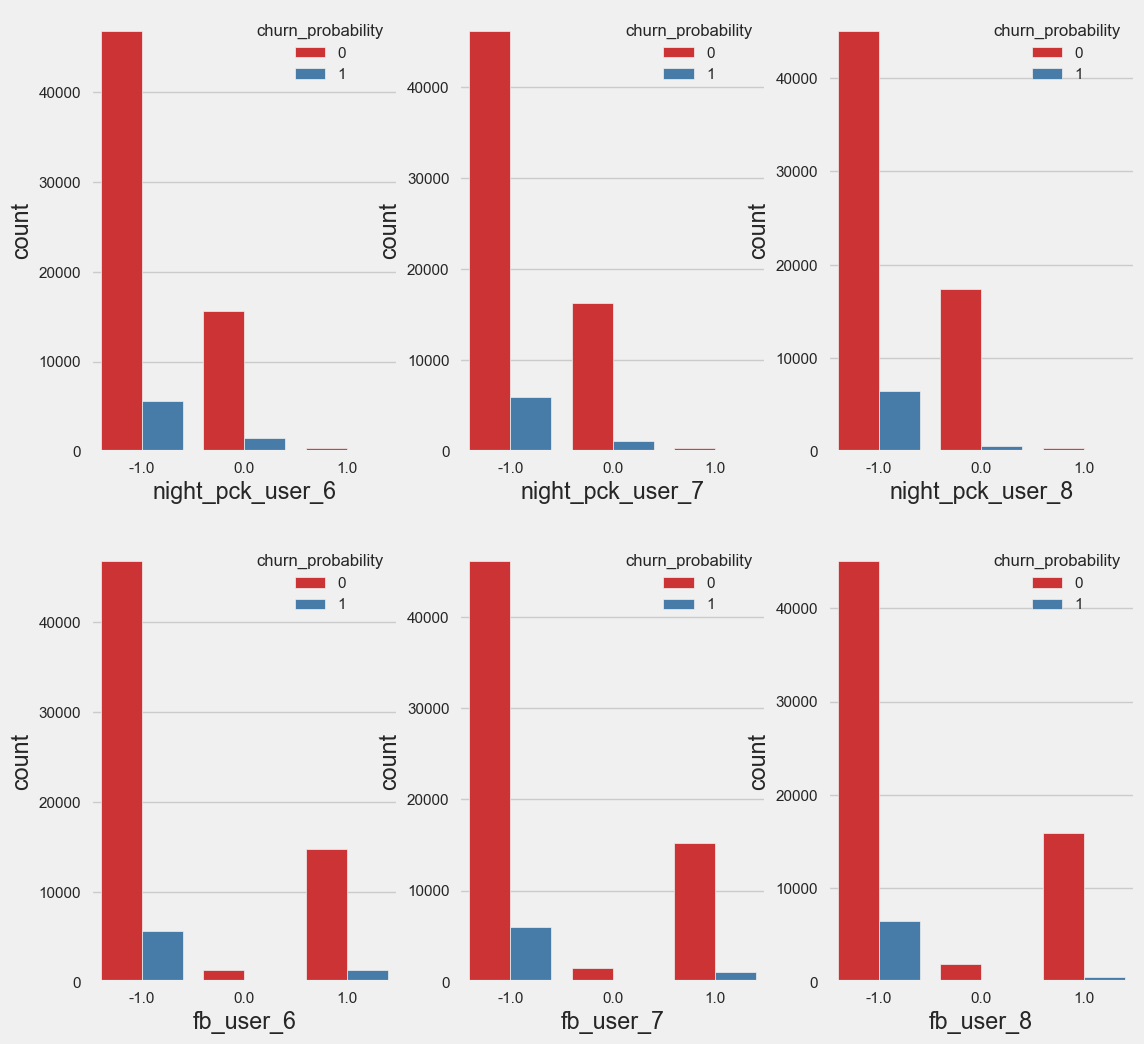

In [269]:
plt.figure(figsize=(12, 12))

for i in range(1,7):
    col = cat_cols[i-1]
    plt.subplot(2,3,i)
    sns.countplot(data= cat_data_for_analysis, x = col, hue = 'churn_probability')

## Numerical Data Analysis

In [272]:
final_data_after_imputation.shape

(69999, 144)

In [271]:
num_cols = list(set(final_data_after_imputation.columns) - set(cat_cols))
len(num_cols)

138

In [286]:
batch_1 = final_data_after_imputation.iloc[:,:20]
batch_1['churn_probability'] = final_data_after_imputation['churn_probability']

batch_2 = final_data_after_imputation.iloc[:,20:40]
batch_2['churn_probability'] = final_data_after_imputation['churn_probability']

batch_3 = final_data_after_imputation.iloc[:,40:60]
batch_3['churn_probability'] = final_data_after_imputation['churn_probability']

batch_4 = final_data_after_imputation.iloc[:,60:80]
batch_4['churn_probability'] = final_data_after_imputation['churn_probability']

batch_5 = final_data_after_imputation.iloc[:,80:100]
batch_5['churn_probability'] = final_data_after_imputation['churn_probability']

batch_6 = final_data_after_imputation.iloc[:,100:120]
batch_6['churn_probability'] = final_data_after_imputation['churn_probability']

batch_7 = final_data_after_imputation.iloc[:,120:]
batch_7['churn_probability'] = final_data_after_imputation['churn_probability']

# batch_8 = final_data_after_imputation.iloc[:,98:112]
# batch_8['churn_probability'] = final_data_after_imputation['churn_probability']

# batch_9 = final_data_after_imputation.iloc[:,112:126]
# batch_9['churn_probability'] = final_data_after_imputation['churn_probability']

# batch_10 = final_data_after_imputation.iloc[:,126:]
# batch_10['churn_probability'] = final_data_after_imputation['churn_probability']

### PairPlot

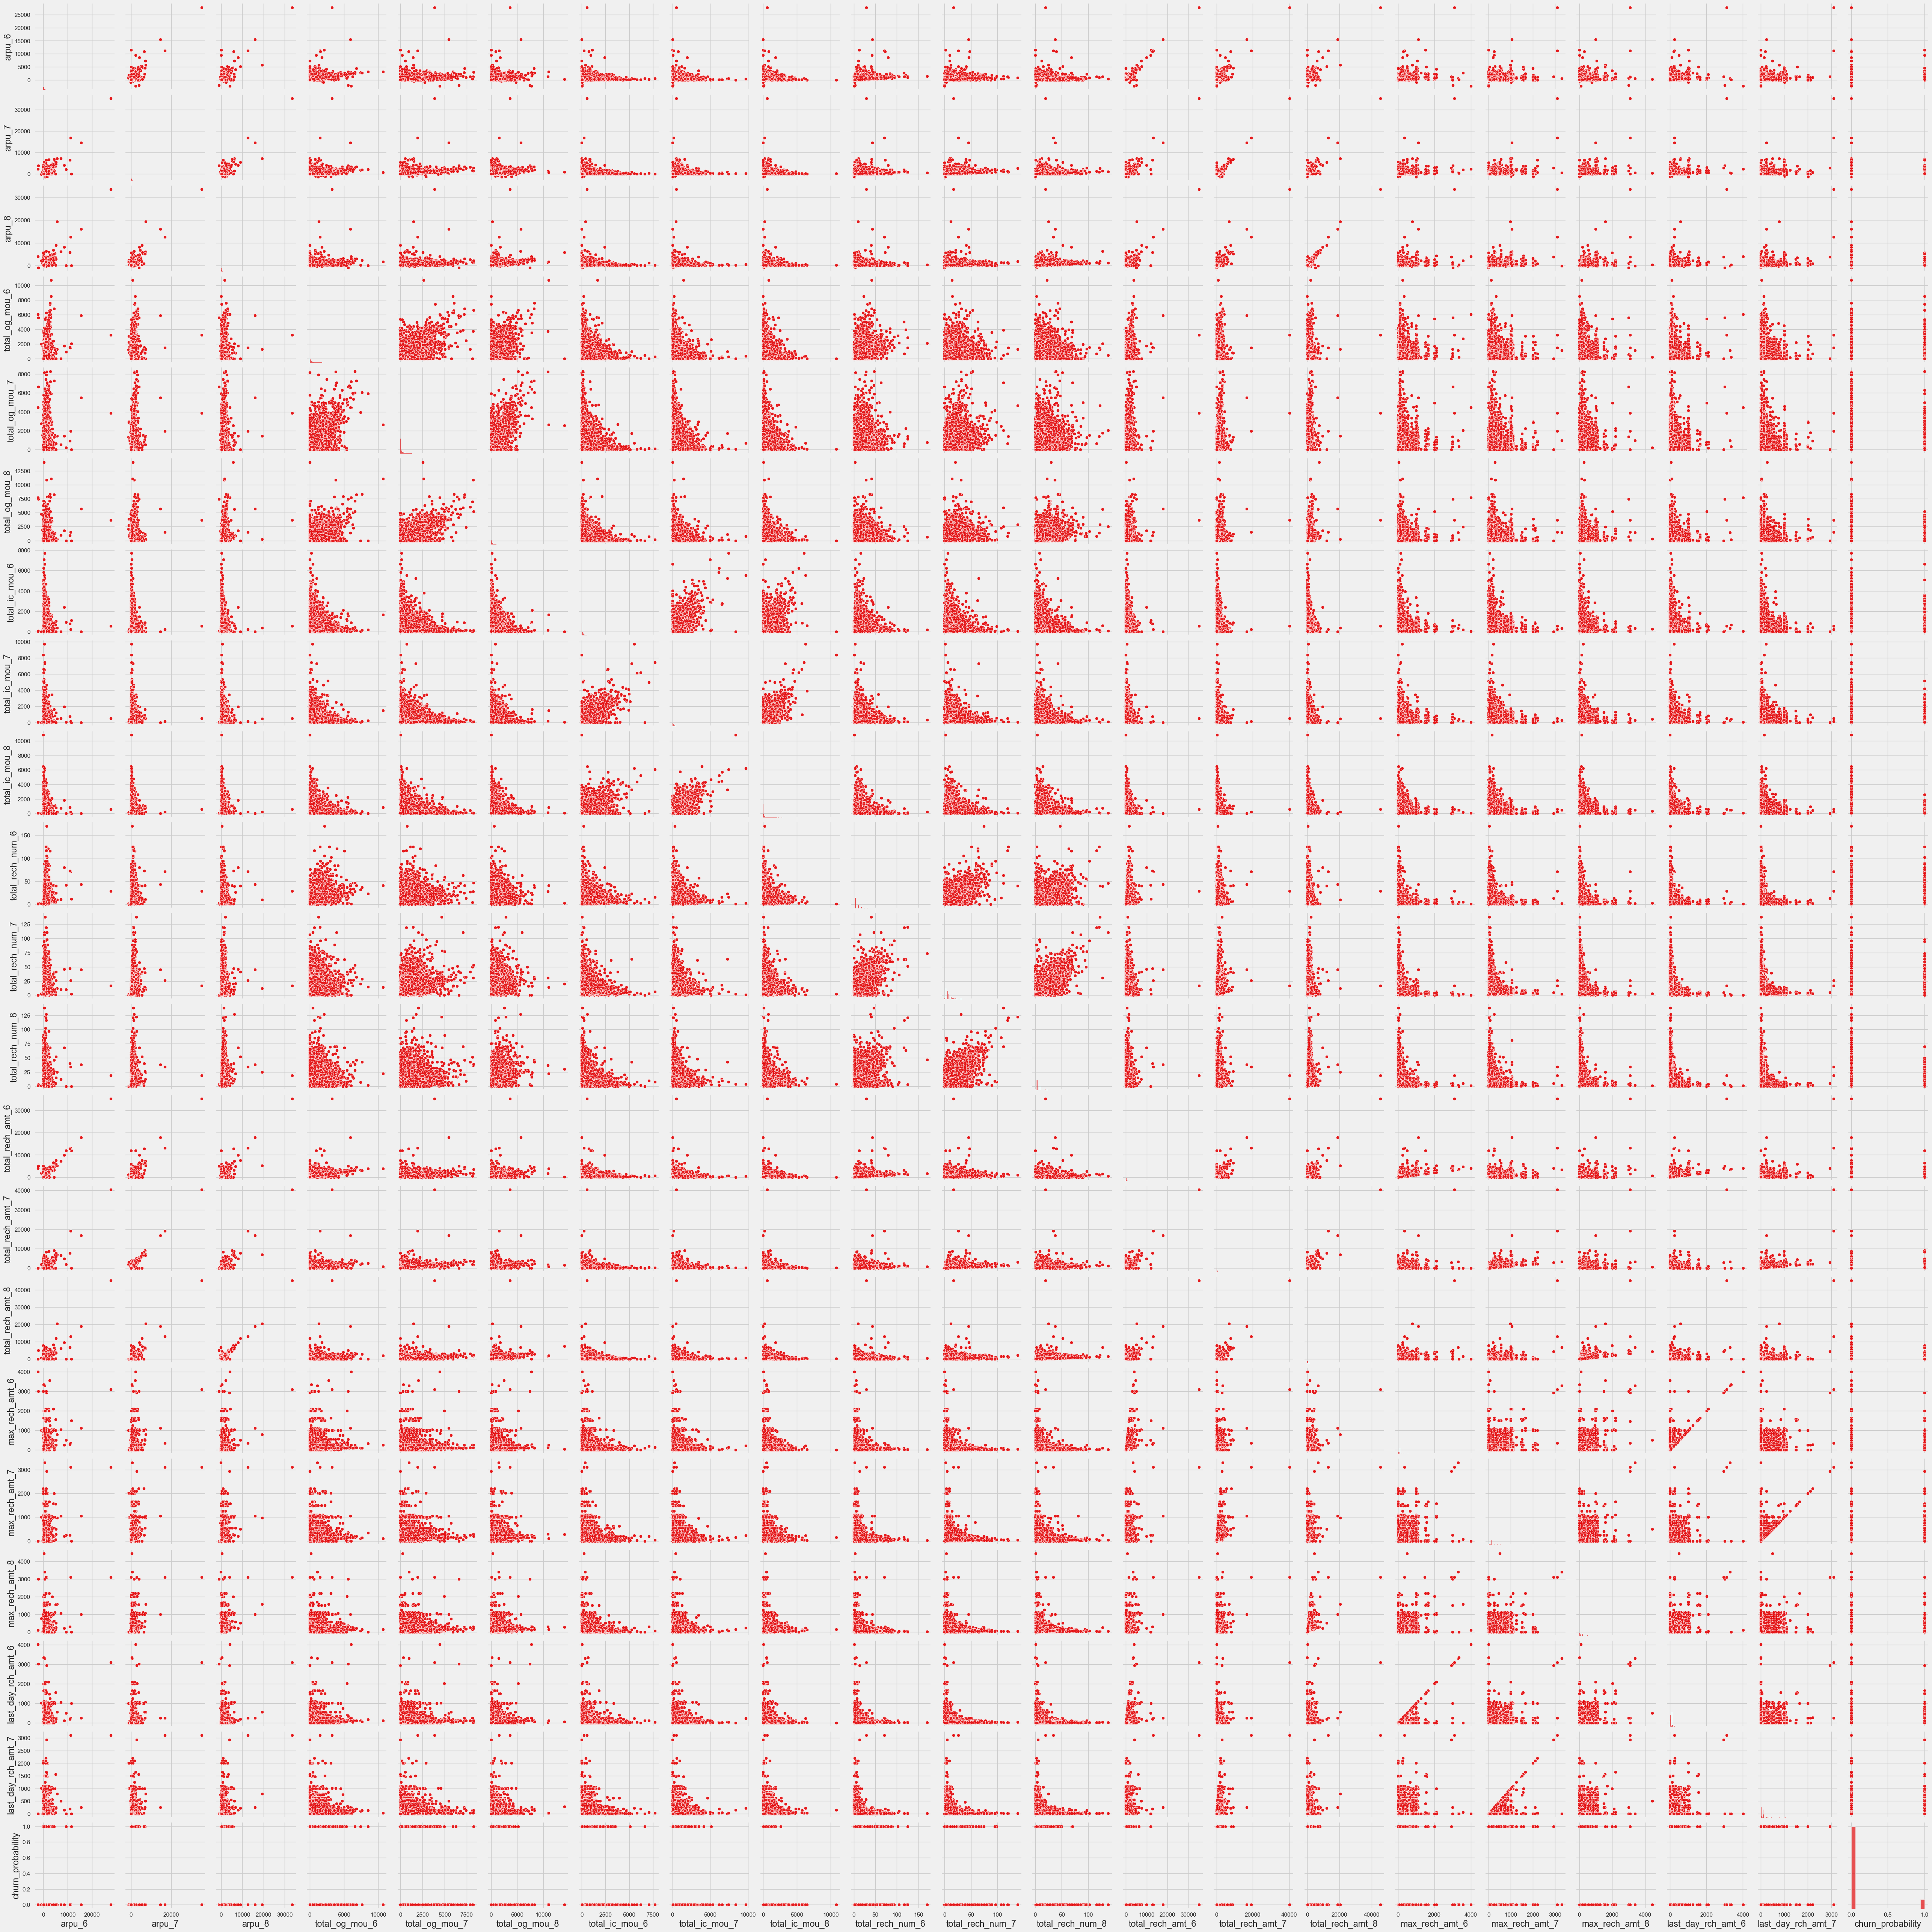

In [302]:
sns.pairplot(batch_1)

### ScatterPlot

<AxesSubplot:xlabel='std_og_t2t_mou_8', ylabel='total_og_mou_8'>

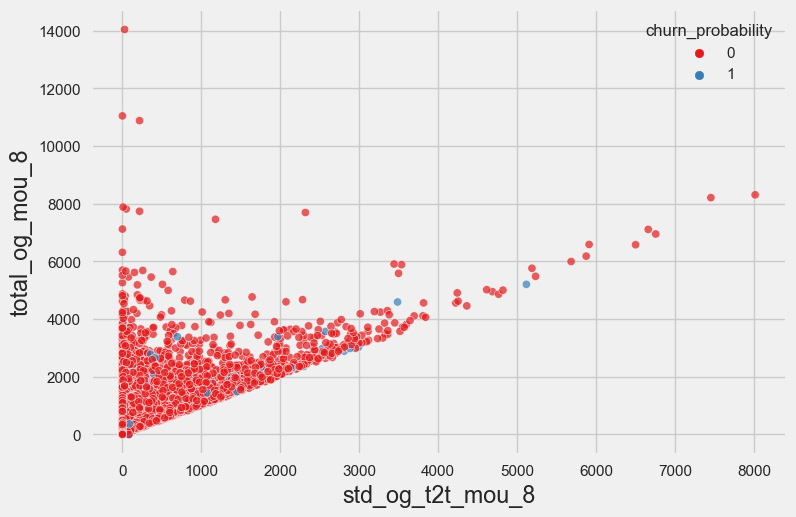

In [307]:
sns.scatterplot(data=final_data_after_imputation, x='std_og_t2t_mou_8', y='total_og_mou_8', hue='churn_probability', alpha=0.7)

<AxesSubplot:xlabel='av_rech_amt_data_8', ylabel='total_rech_data_8'>

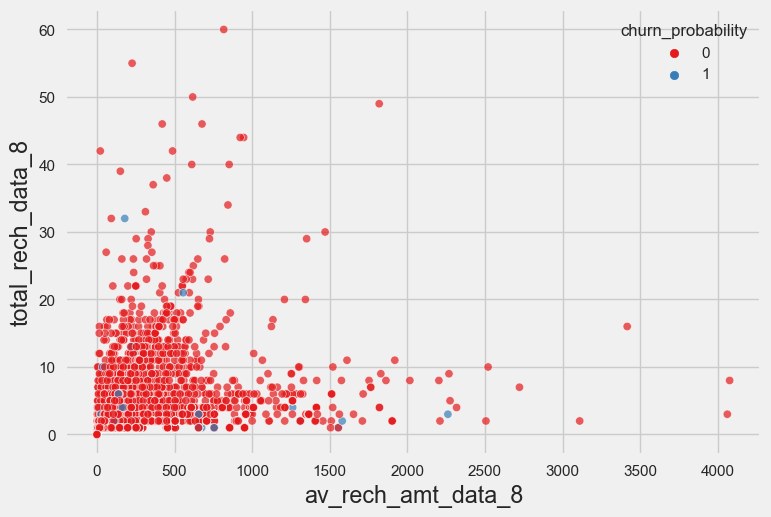

In [308]:
sns.scatterplot(data=final_data_after_imputation, x='av_rech_amt_data_8', y='total_rech_data_8', hue='churn_probability', alpha=0.7)

### HeatMap

Note: We have set the threshold to 0.80. Therefore, only values >= 0.80 'll be displayed.

<AxesSubplot:>

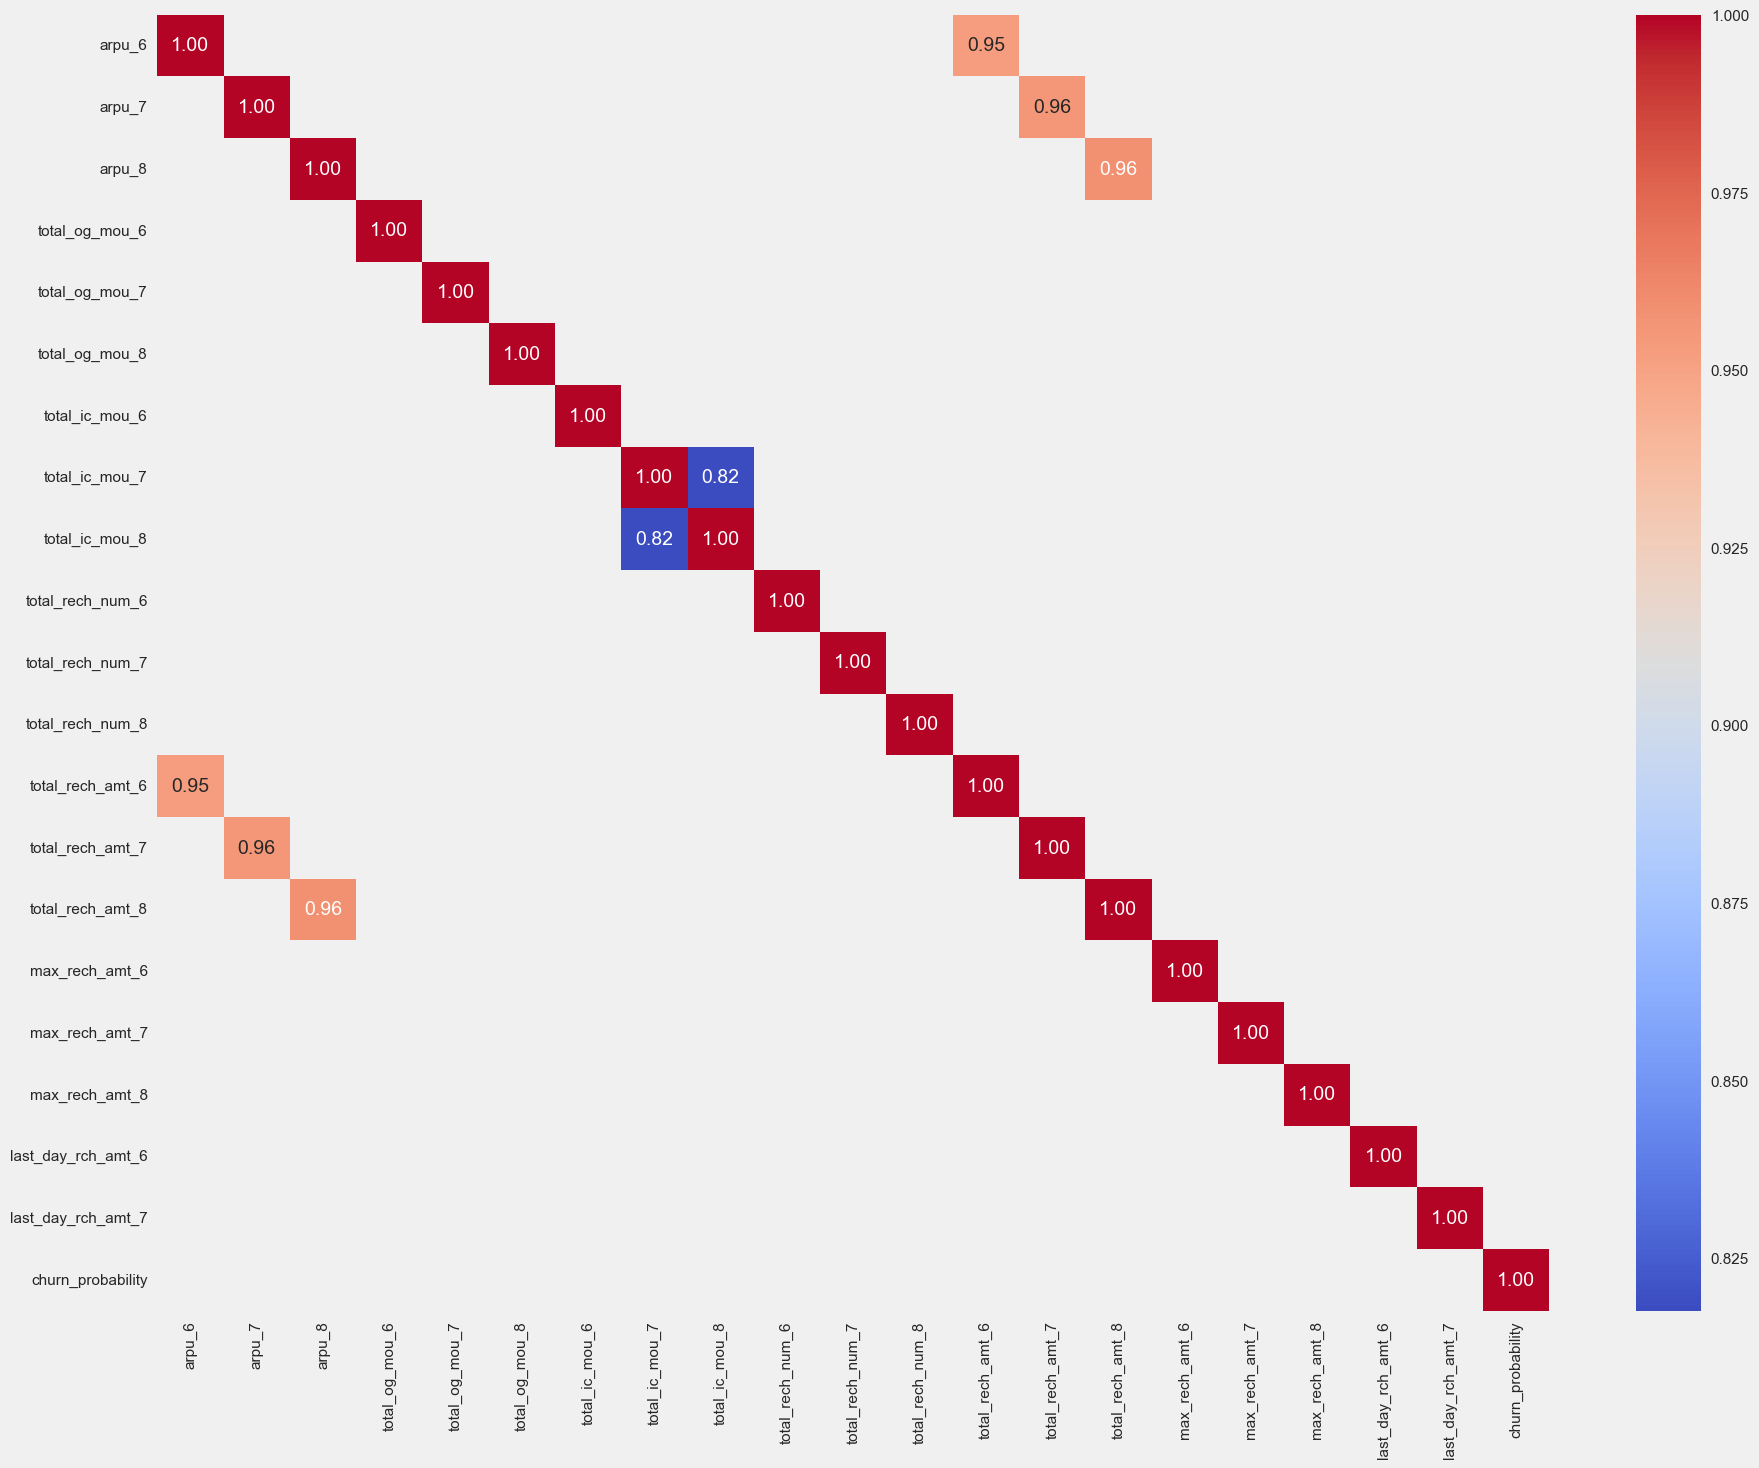

In [295]:
get_corr_heatmap(batch_1)

<AxesSubplot:>

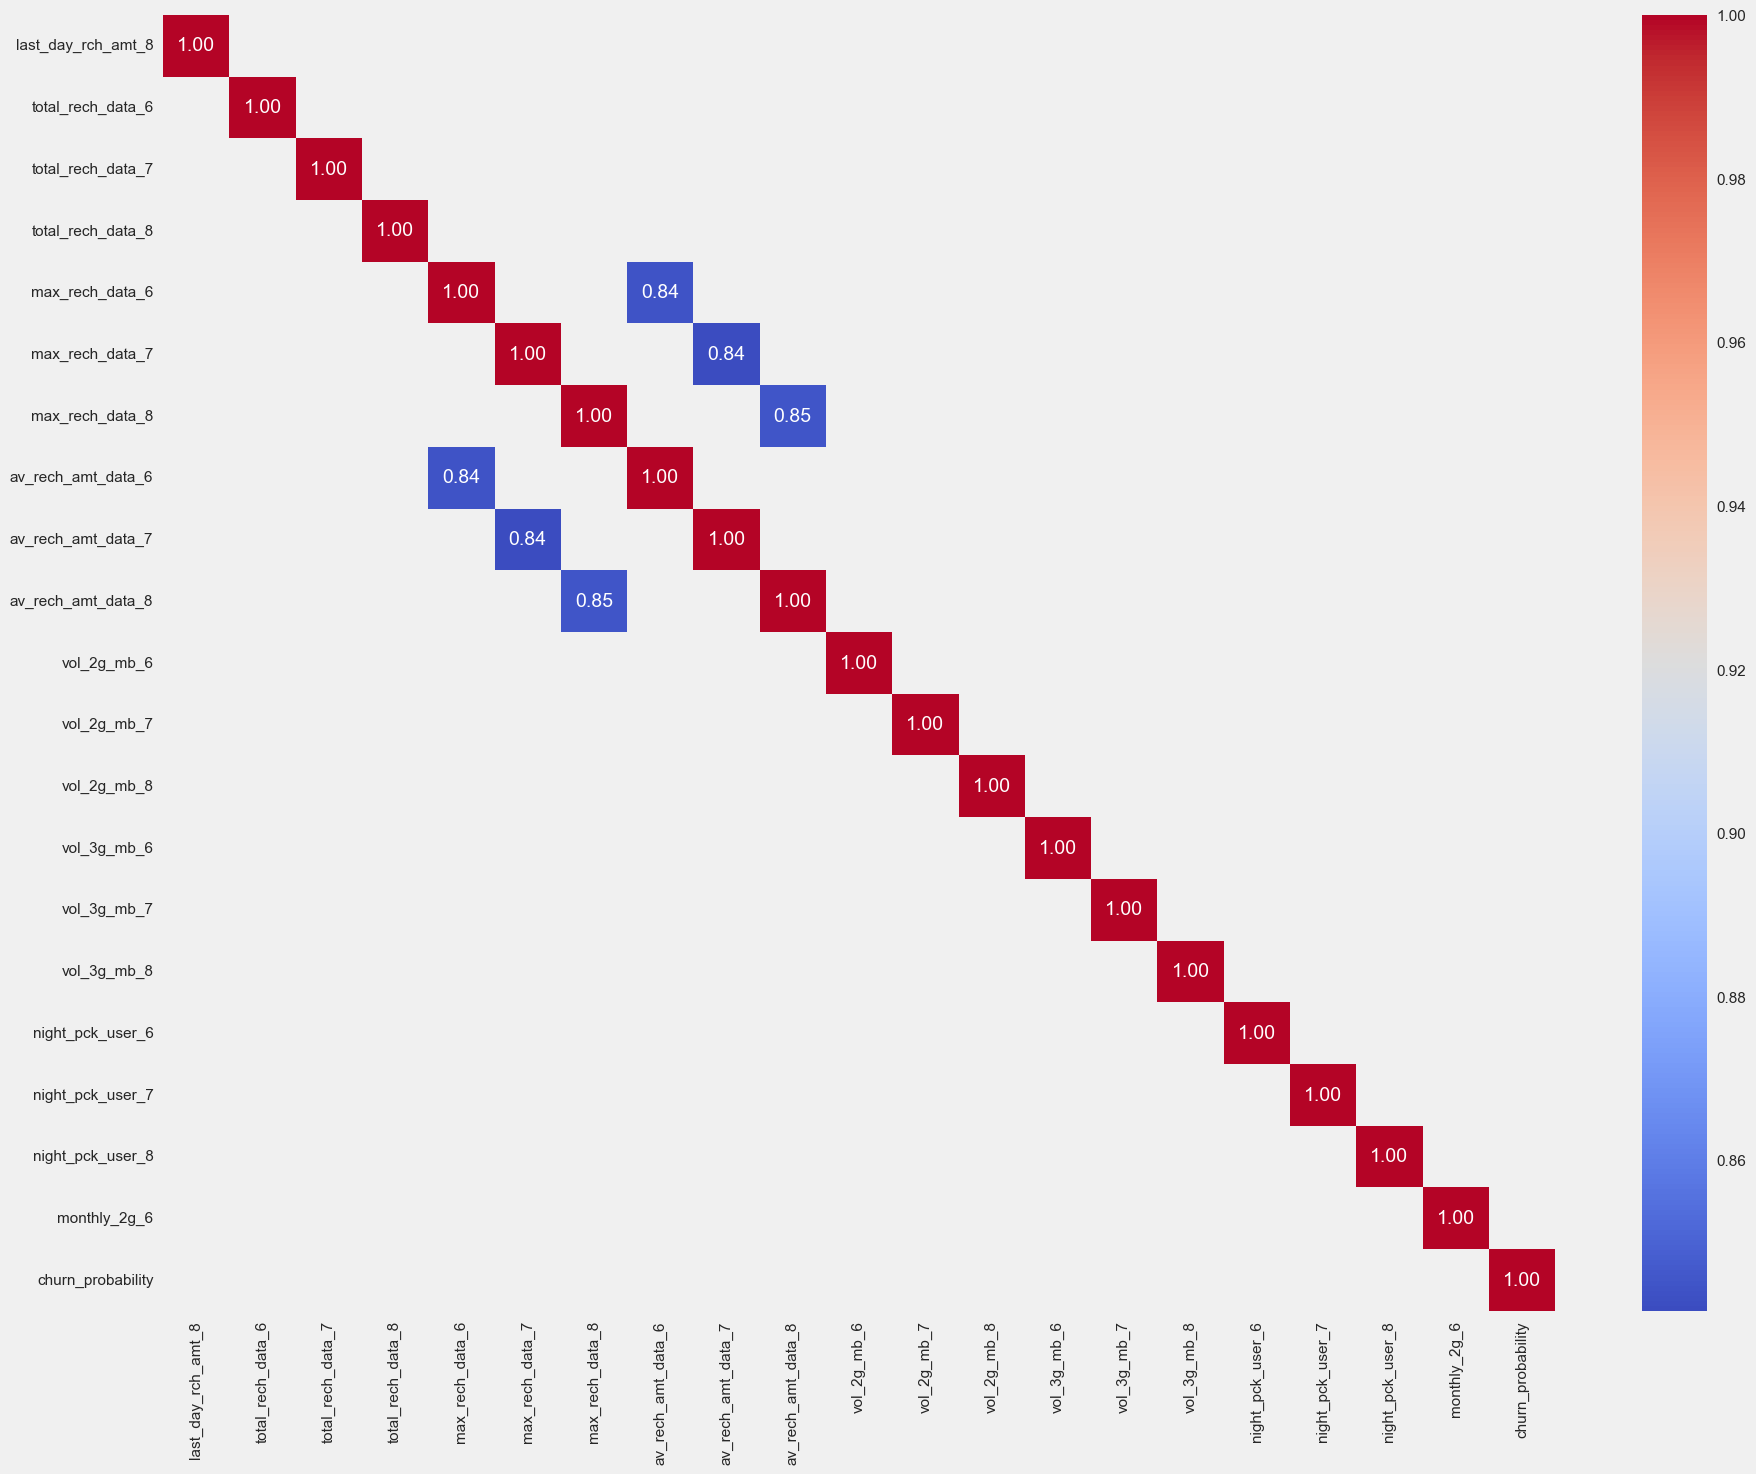

In [296]:
get_corr_heatmap(batch_2)

<AxesSubplot:>

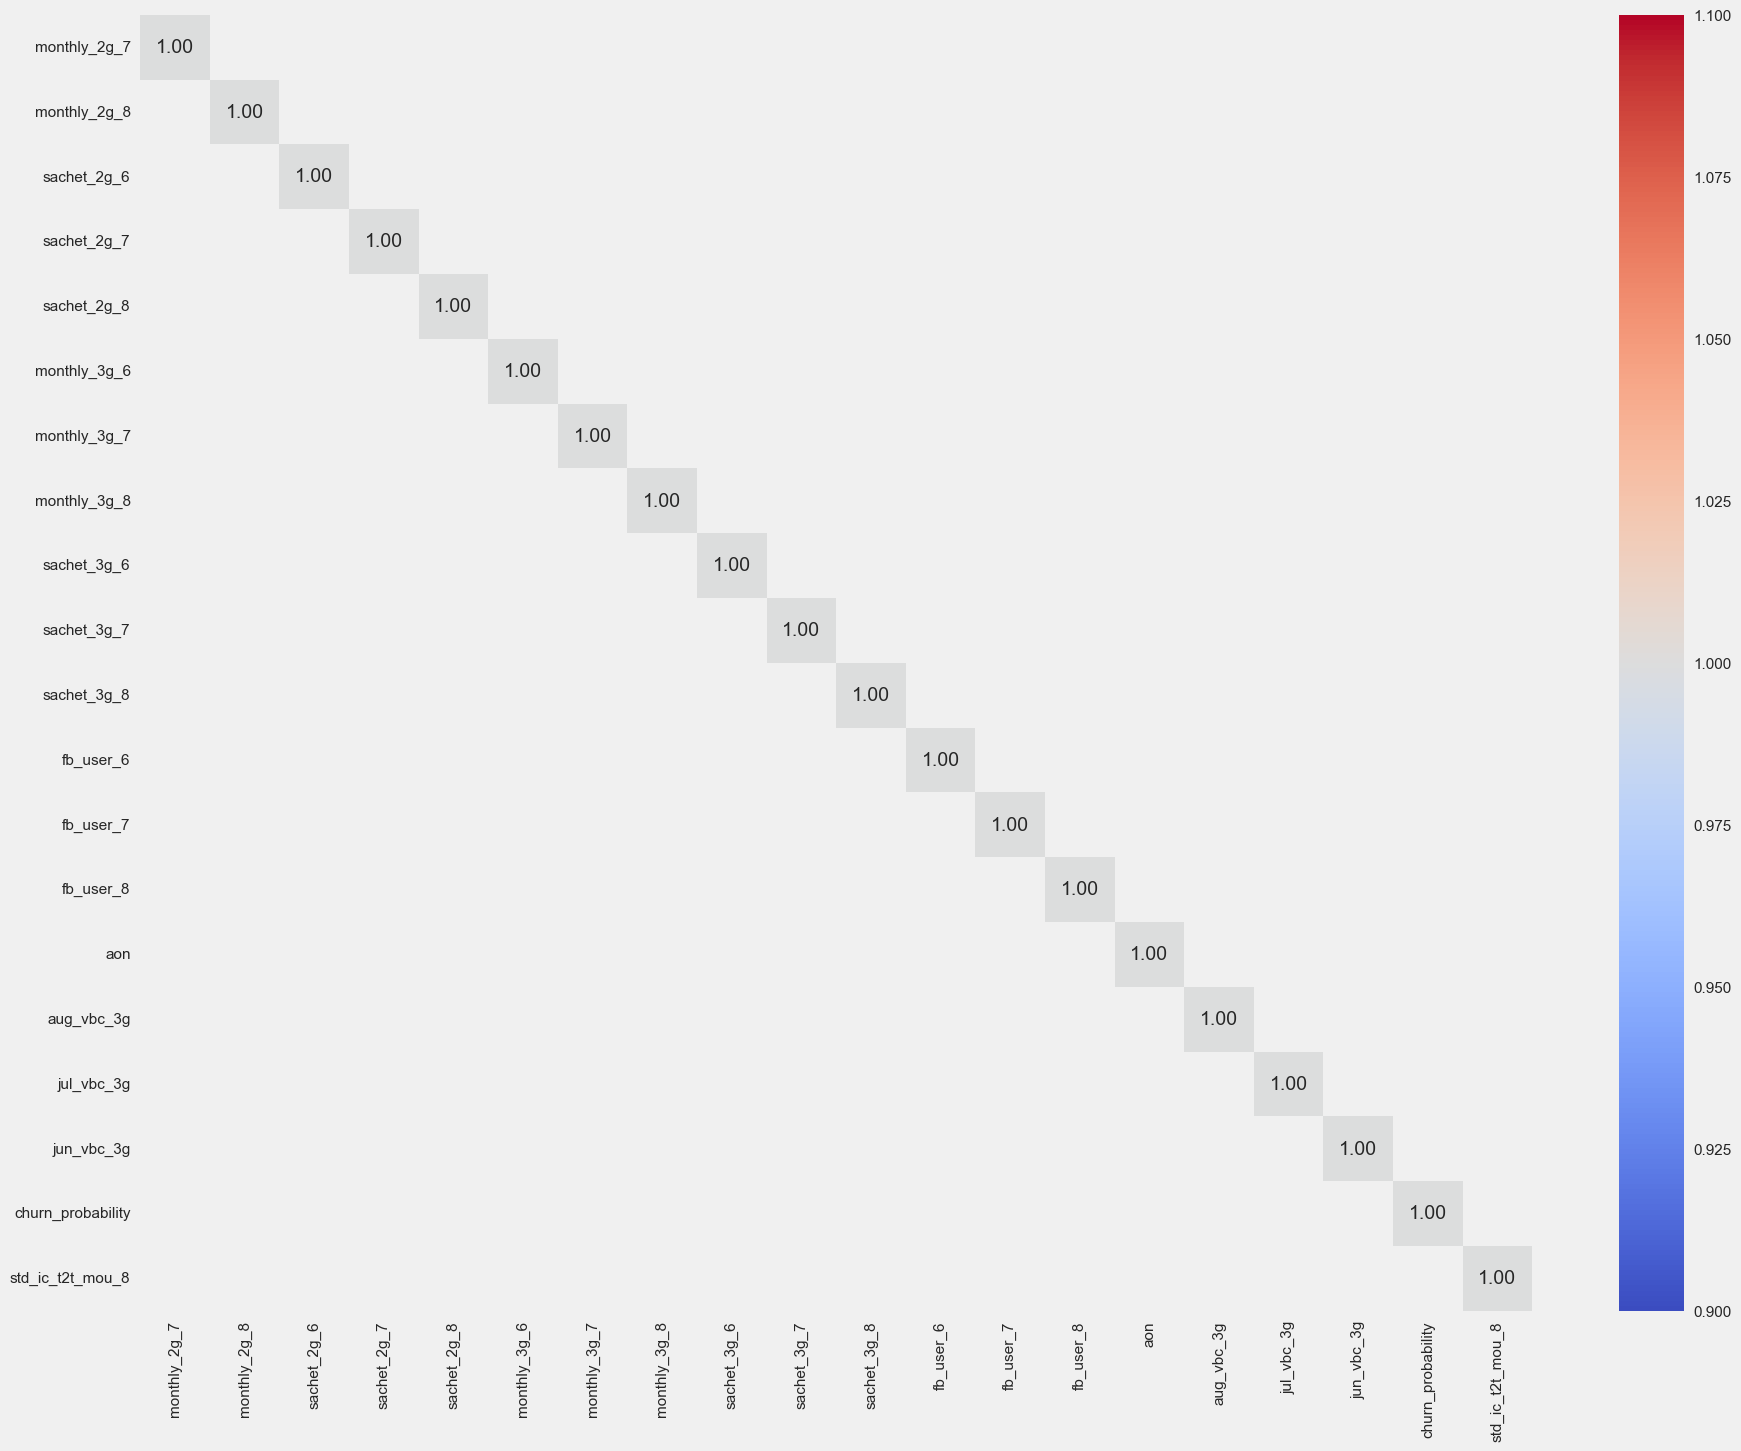

In [297]:
get_corr_heatmap(batch_3)

<AxesSubplot:>

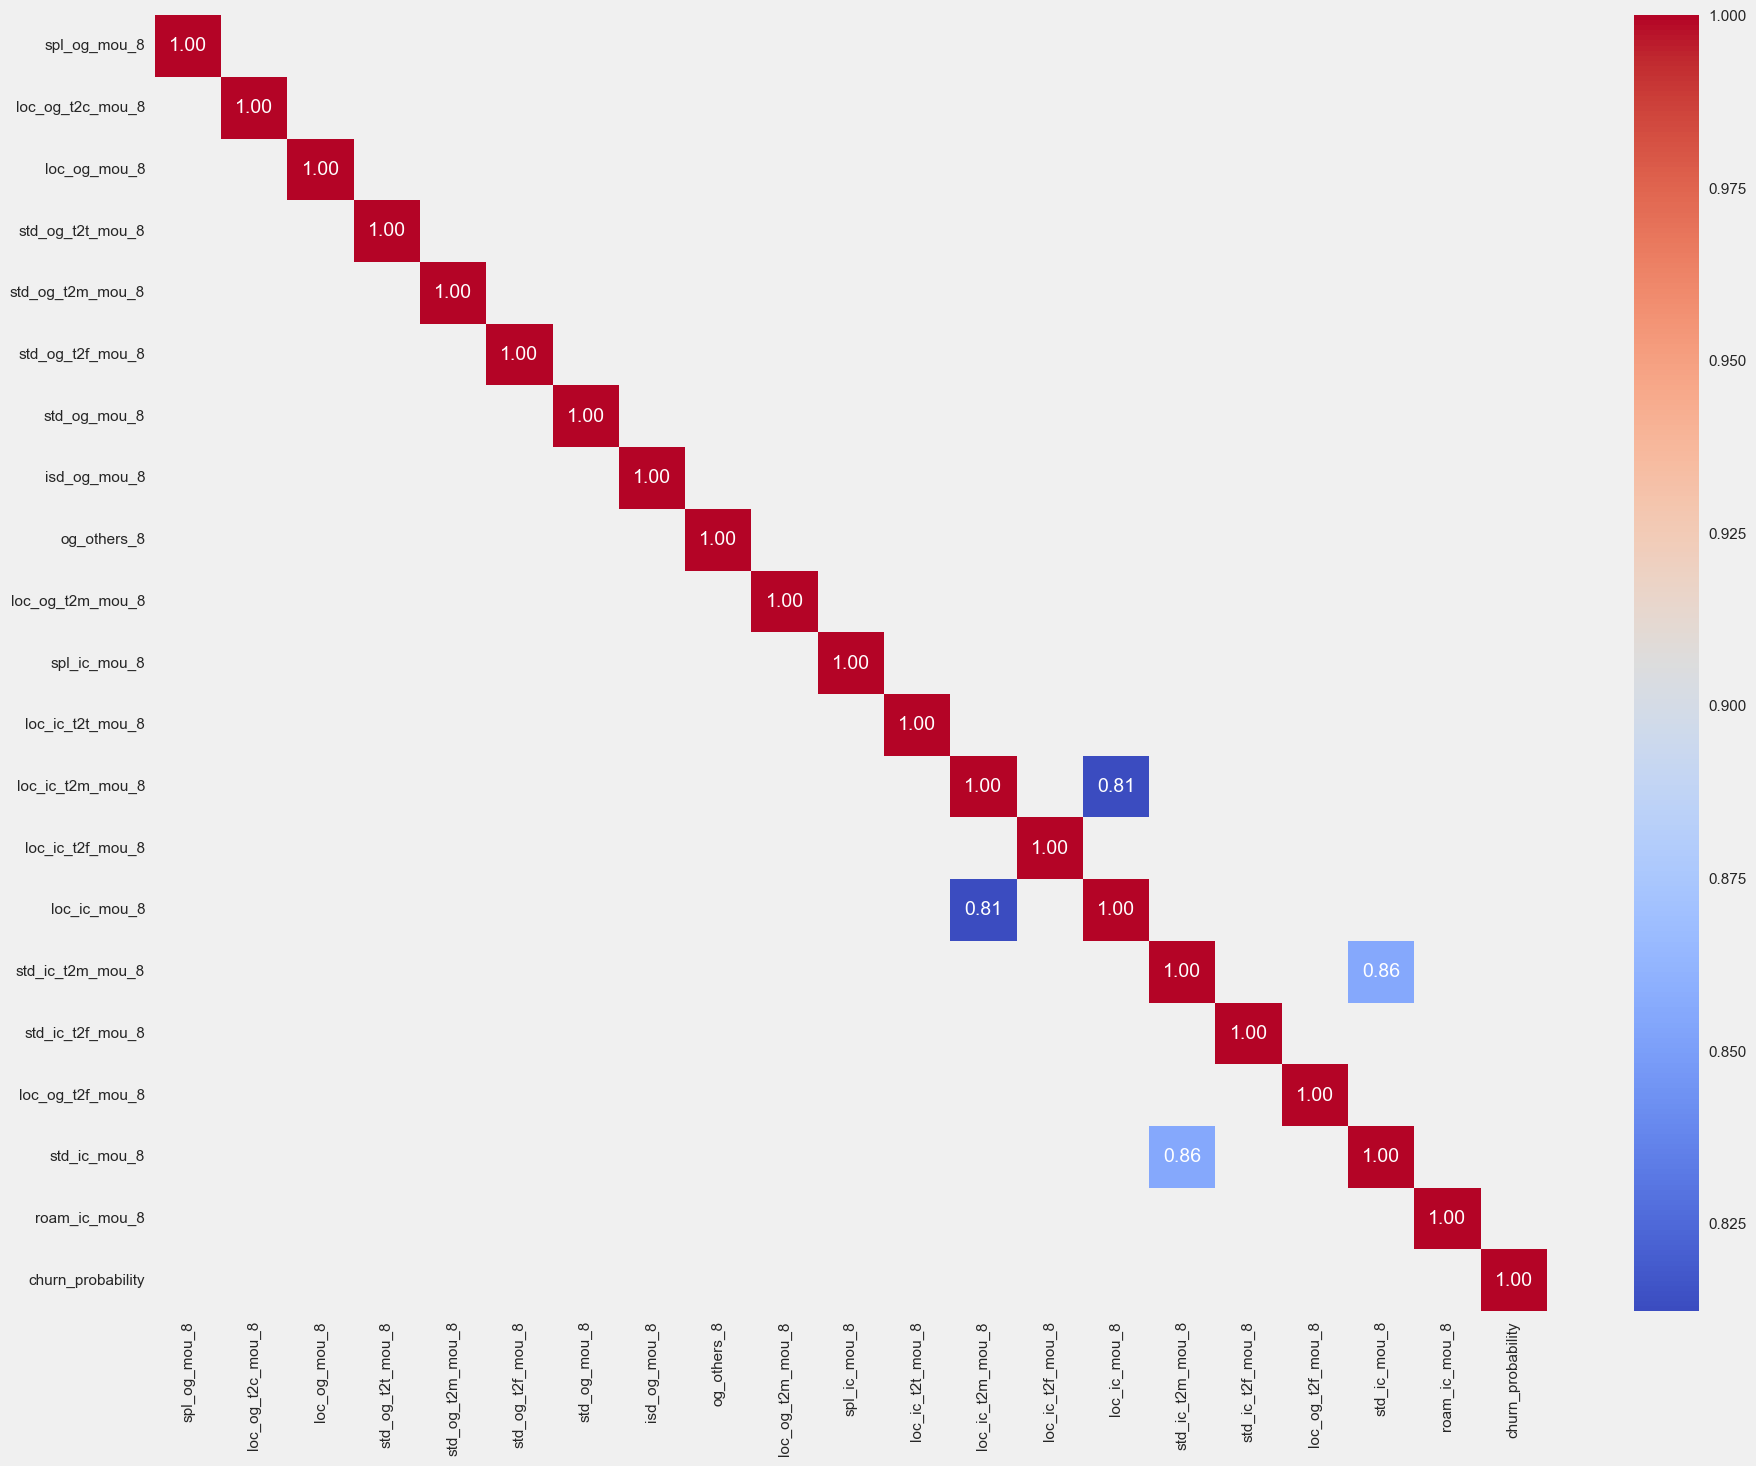

In [298]:
get_corr_heatmap(batch_4)

<AxesSubplot:>

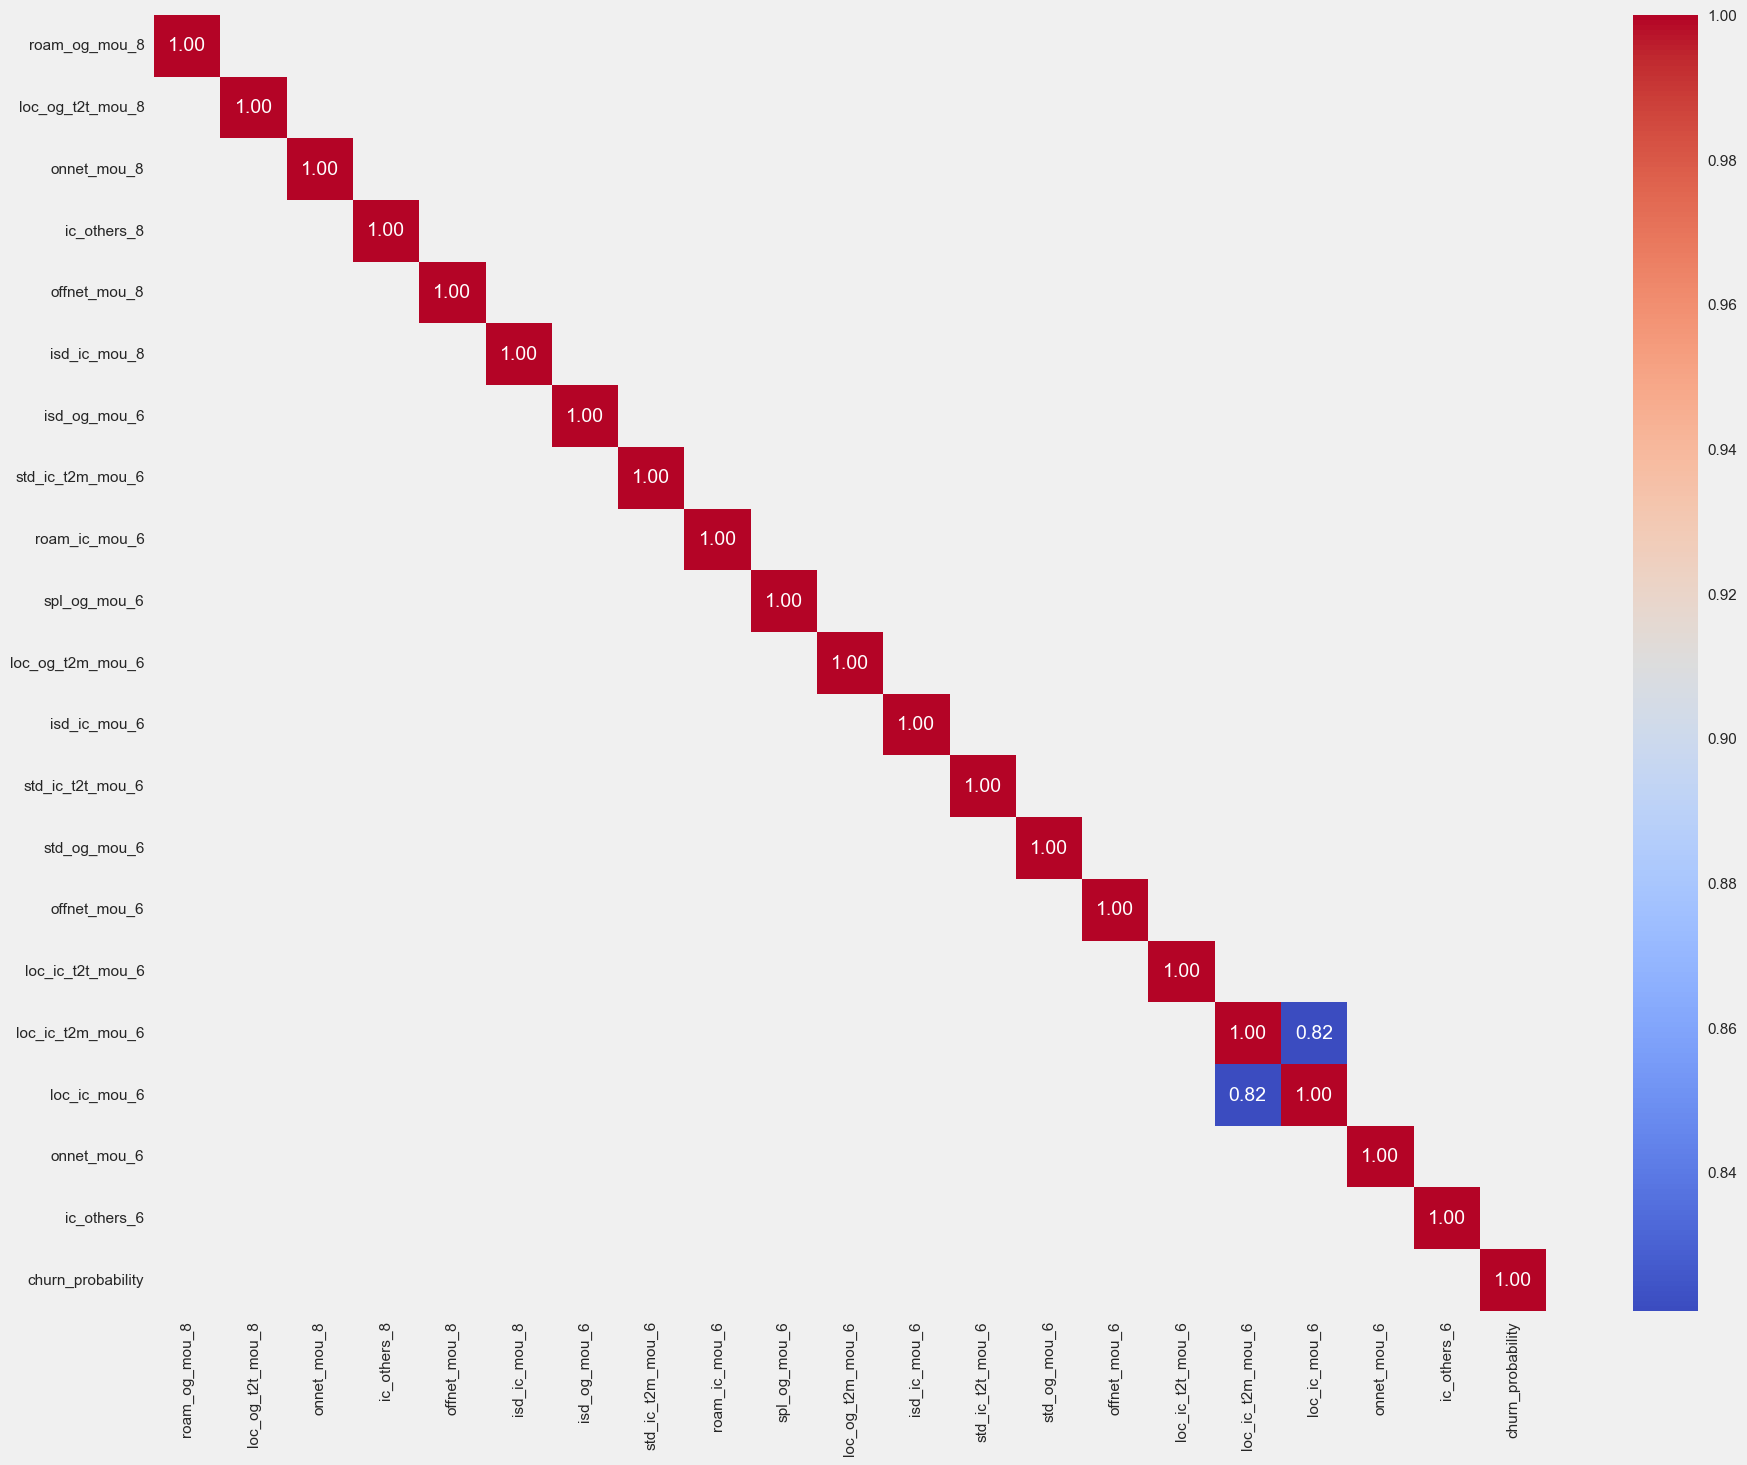

In [299]:
get_corr_heatmap(batch_5)

<AxesSubplot:>

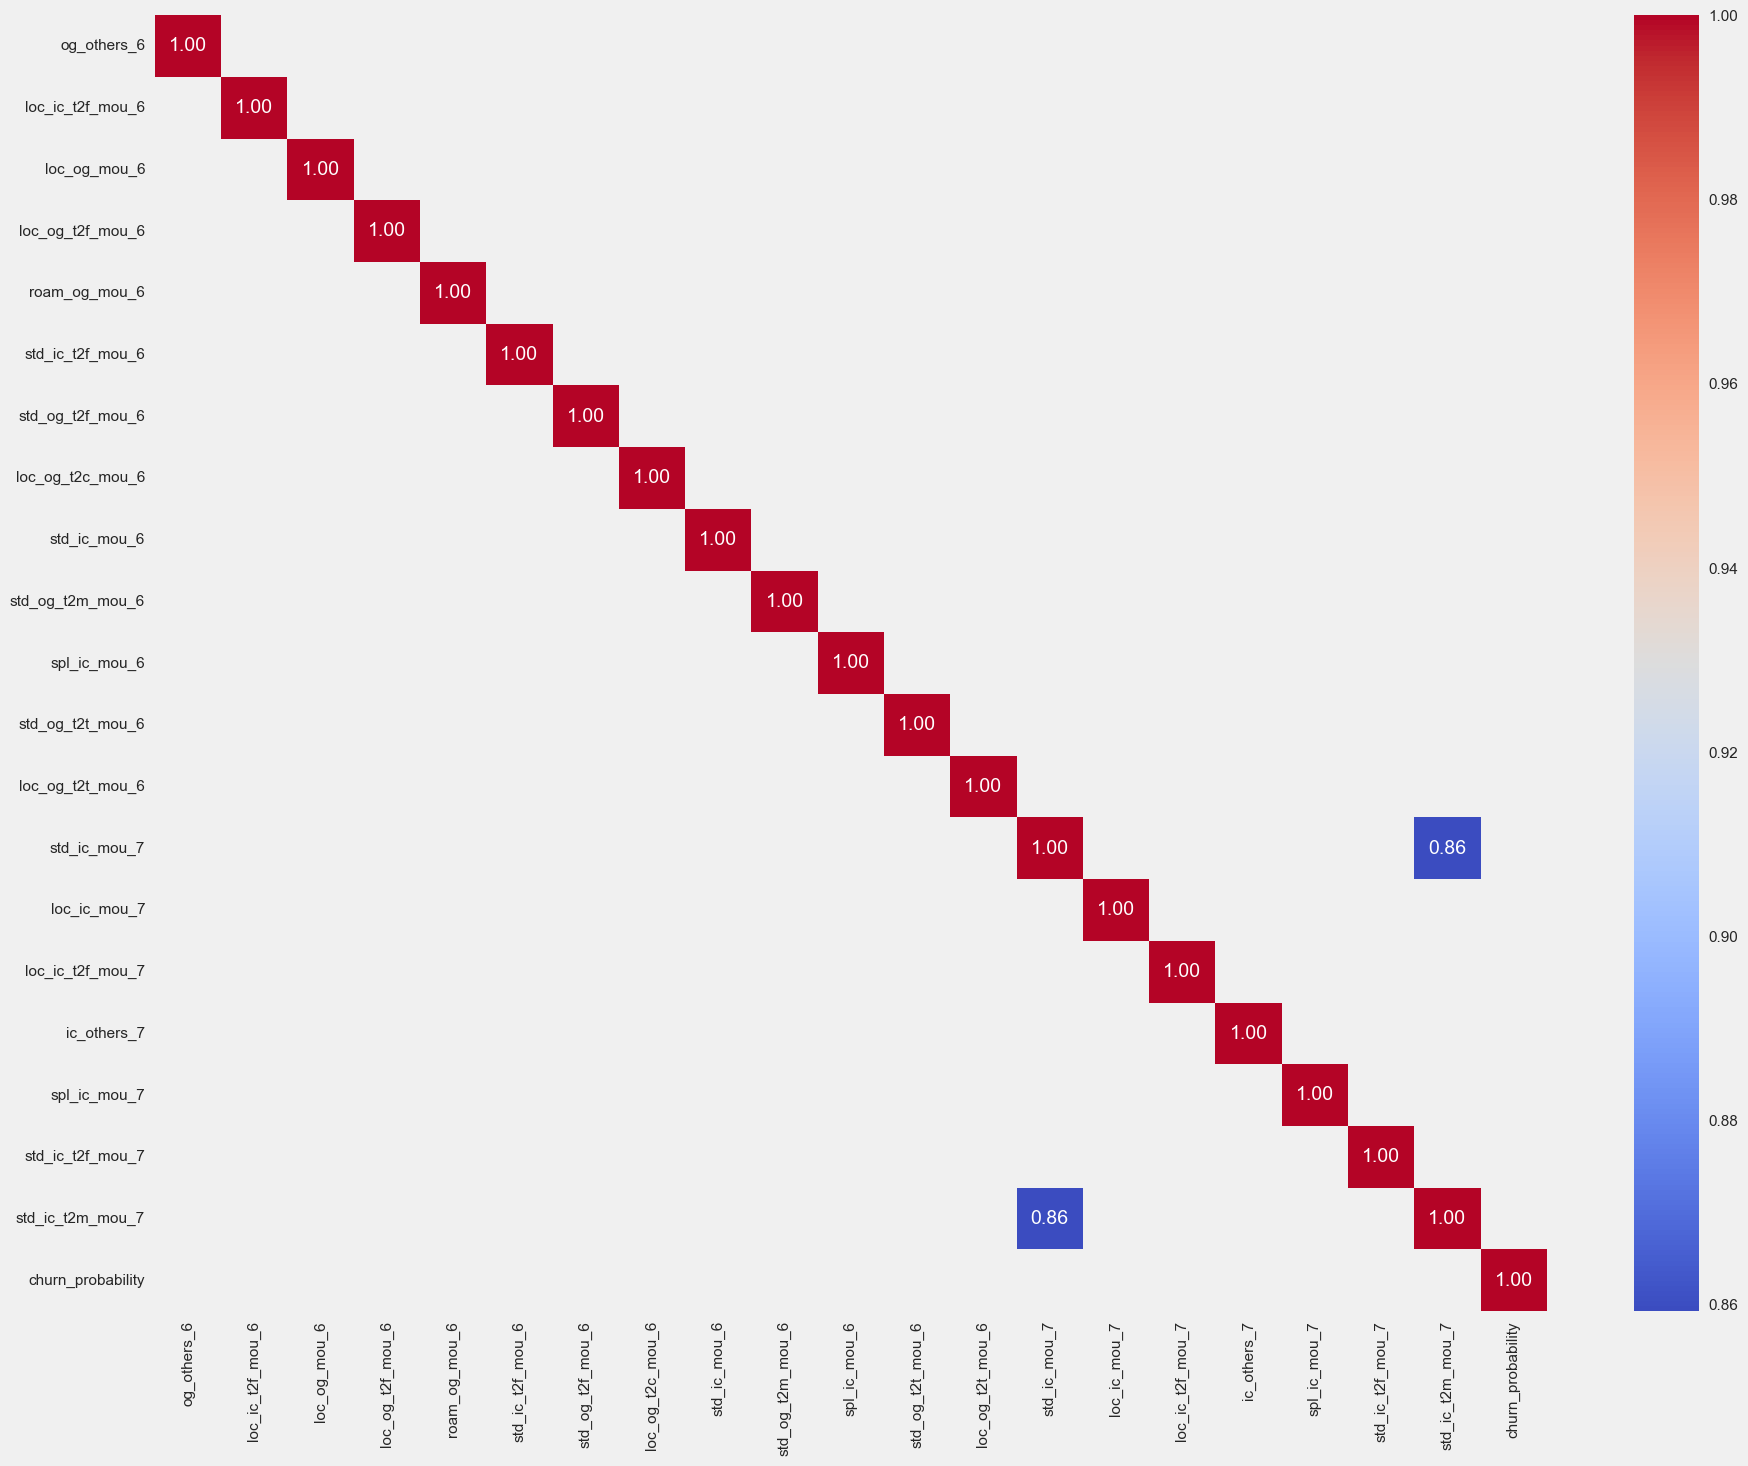

In [300]:
get_corr_heatmap(batch_6)

<AxesSubplot:>

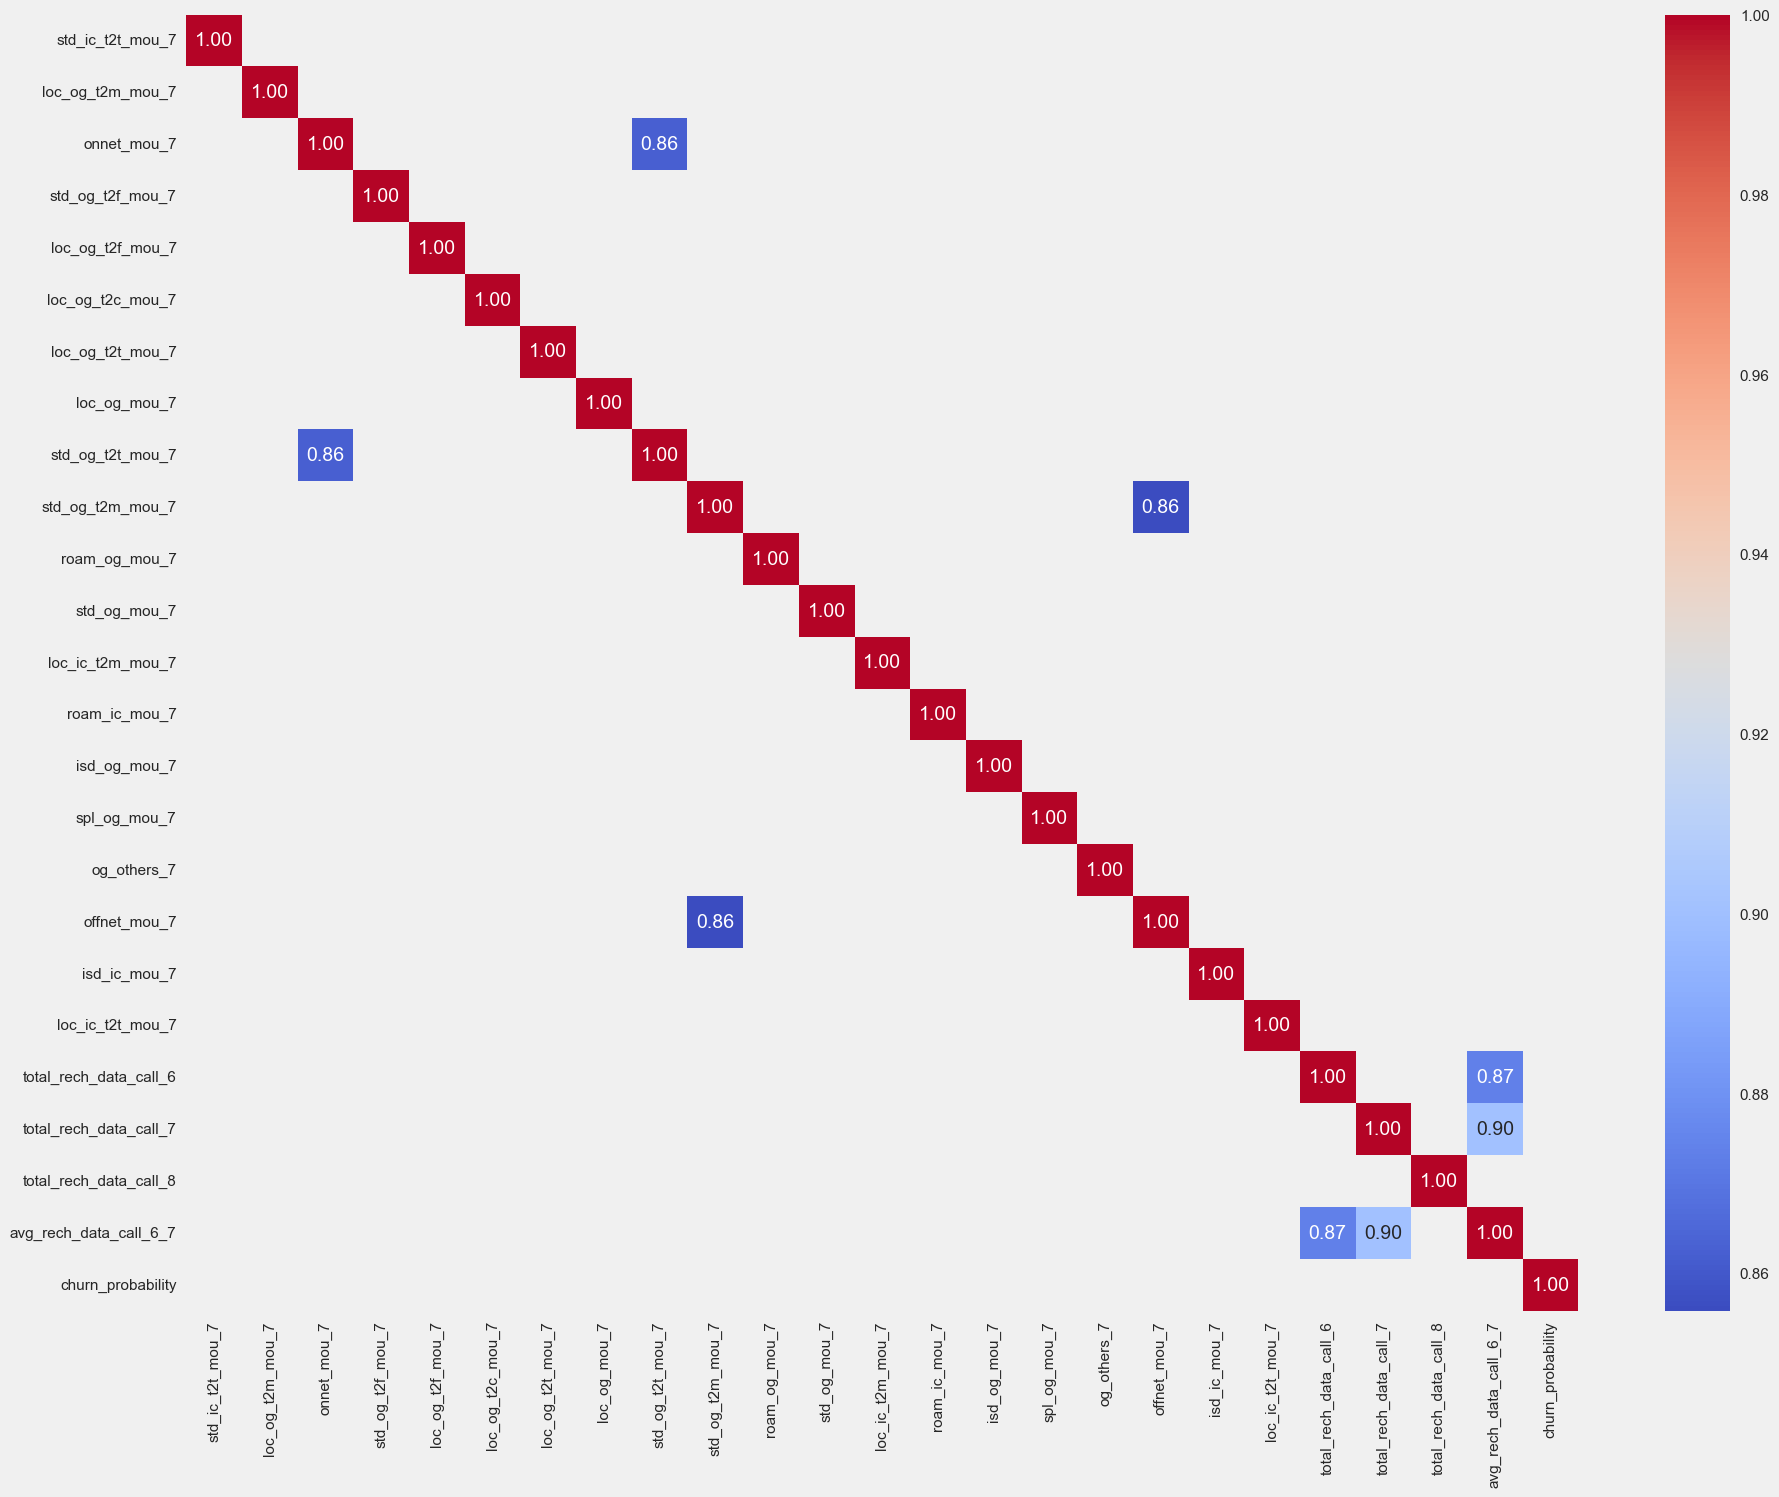

In [301]:
get_corr_heatmap(batch_7)

#### Findings

1. 'total_rech_amt_6', 'total_rech_amt_7' & 'total_rech_amt_8' is highly correlated with 'arpu_6', 'arpu_7' & 'arpu_8' respectively.
2. 'total_ic_mou_7' is highly correlated with ''total_ic_mou_8'
3. 'av_rech_amt_data_6', 'av_rech_amt_data_7' & 'av_rech_amt_data_8' is highly correlated with 'max_rech_data_6', 'max_rech_data_7' & 'max_rech_data_8' respectively
4. 'loc_ic_mou_8' is highly correlated with 'loc_ic_t2m_mou_8'
5. 'std_ic_mou_8' is highly correlated with 'std_ic_t2m_mou_8'
6. 'loc_ic_mou_6' is highly correlated with 'loc_ic_t2m_mou_6'
7. 'std_ic_mou_7' is highly correlated with 'std_ic_t2m_mou_7'
8. 'onnet_mou_7' & 'std_og_t2m_mou_7' is highly correlated with 'std_og_t2t_mou_7' & 'onnet_mou_7' respectively.

# Data Preparation

In [91]:
final_data = copy.deepcopy(final_data_after_imputation_filtered)
final_data.head()

arpu_6   arpu_7   arpu_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0  240.708  128.191  101.565           63.26           42.94           15.76   
1  167.861  167.869  167.866            0.00            0.00            0.00   
2  439.919  397.946  392.024          816.44          836.23          687.41   
3  580.549  377.294  338.286          327.64          366.79          391.53   
4  277.458  283.346  231.755          498.23          543.16          436.23   

   total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  total_rech_num_6  ...  \
0           21.54            9.36           28.31              13.0  ...   
1           25.11           15.89           43.83               2.0  ...   
2           34.49           35.34           26.99              15.0  ...   
3          233.18          777.39          629.94               5.0  ...   
4          238.29          545.58          565.38               6.0  ...   

   roam_og_mou_7  std_og_mou_7  loc_ic_t2m_mou_7  roam_ic_mou_7  isd_og_mou_7  \
0            0.0          0.00          4.330000            0.0           0.0   
1            0.0          0.00          9.160000            0.0           0.0   
2            0.0        814.43         25.680000            0.0           0.0   
3            0.0          0.00        535.068882            0.0           0.0   
4            0.0          0.41        302.530000            0.0           0.0   

   spl_og_mou_7  og_others_7  offnet_mou_7  isd_ic_mou_7  loc_ic_t2t_mou_7  
0          17.0          0.0         38.11           0.0              1.39  
1           0.0          0.0          0.00           0.0              6.04  
2           0.0          0.0        727.91           0.0              0.53  
3           0.0          0.0        341.79           0.0             20.18  
4           0.0          0.0        255.18           0.0            217.16  

[5 rows x 140 columns]

## Creating Dummy Variables

In [92]:
cat_cols

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [93]:
final_data.shape

(28029, 140)

In [94]:
# Creating dummy variables
for col in cat_cols:
    final_data = create_dummies(final_data, col)
final_data.shape

(28029, 146)

In [95]:
final_data.head()

arpu_6   arpu_7   arpu_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0  240.708  128.191  101.565           63.26           42.94           15.76   
1  167.861  167.869  167.866            0.00            0.00            0.00   
2  439.919  397.946  392.024          816.44          836.23          687.41   
3  580.549  377.294  338.286          327.64          366.79          391.53   
4  277.458  283.346  231.755          498.23          543.16          436.23   

   total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  total_rech_num_6  ...  \
0           21.54            9.36           28.31              13.0  ...   
1           25.11           15.89           43.83               2.0  ...   
2           34.49           35.34           26.99              15.0  ...   
3          233.18          777.39          629.94               5.0  ...   
4          238.29          545.58          565.38               6.0  ...   

   night_pck_user_7_0.0  night_pck_user_7_1.0  night_pck_user_8_0.0  \
0                     1                     0                     1   
1                     1                     0                     1   
2                     0                     0                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   night_pck_user_8_1.0  fb_user_6_0.0  fb_user_6_1.0  fb_user_7_0.0  \
0                     0              0              1              0   
1                     0              0              1              0   
2                     0              0              0              0   
3                     0              0              1              0   
4                     0              0              0              0   

   fb_user_7_1.0  fb_user_8_0.0  fb_user_8_1.0  
0              1              0              1  
1              1              0              1  
2              0              0              0  
3              0              0              1  
4              0              0              0  

[5 rows x 146 columns]

## Feature Engineering

In [96]:
final_data['arpu_diff'] = final_data.arpu_8 - ((final_data.arpu_6 + final_data.arpu_7)/2)

final_data['onnet_mou_diff'] = final_data.onnet_mou_8 - ((final_data.onnet_mou_6 + final_data.onnet_mou_7)/2)

final_data['offnet_mou_diff'] = final_data.offnet_mou_8 - ((final_data.offnet_mou_6 + final_data.offnet_mou_7)/2)

final_data['roam_ic_mou_diff'] = final_data.roam_ic_mou_8 - ((final_data.roam_ic_mou_6 + final_data.roam_ic_mou_7)/2)

final_data['roam_og_mou_diff'] = final_data.roam_og_mou_8 - ((final_data.roam_og_mou_6 + final_data.roam_og_mou_7)/2)

final_data['loc_og_mou_diff'] = final_data.loc_og_mou_8 - ((final_data.loc_og_mou_6 + final_data.loc_og_mou_7)/2)

final_data['std_og_mou_diff'] = final_data.std_og_mou_8 - ((final_data.std_og_mou_6 + final_data.std_og_mou_7)/2)

final_data['isd_og_mou_diff'] = final_data.isd_og_mou_8 - ((final_data.isd_og_mou_6 + final_data.isd_og_mou_7)/2)

final_data['spl_og_mou_diff'] = final_data.spl_og_mou_8 - ((final_data.spl_og_mou_6 + final_data.spl_og_mou_7)/2)

final_data['total_og_mou_diff'] = final_data.total_og_mou_8 - ((final_data.total_og_mou_6 + final_data.total_og_mou_7)/2)

final_data['loc_ic_mou_diff'] = final_data.loc_ic_mou_8 - ((final_data.loc_ic_mou_6 + final_data.loc_ic_mou_7)/2)

final_data['std_ic_mou_diff'] = final_data.std_ic_mou_8 - ((final_data.std_ic_mou_6 + final_data.std_ic_mou_7)/2)

final_data['isd_ic_mou_diff'] = final_data.isd_ic_mou_8 - ((final_data.isd_ic_mou_6 + final_data.isd_ic_mou_7)/2)

final_data['spl_ic_mou_diff'] = final_data.spl_ic_mou_8 - ((final_data.spl_ic_mou_6 + final_data.spl_ic_mou_7)/2)

final_data['total_ic_mou_diff'] = final_data.total_ic_mou_8 - ((final_data.total_ic_mou_6 + final_data.total_ic_mou_7)/2)

final_data['total_rech_num_diff'] = final_data.total_rech_num_8 - ((final_data.total_rech_num_6 + final_data.total_rech_num_7)/2)

final_data['total_rech_amt_diff'] = final_data.total_rech_amt_8 - ((final_data.total_rech_amt_6 + final_data.total_rech_amt_7)/2)

final_data['max_rech_amt_diff'] = final_data.max_rech_amt_8 - ((final_data.max_rech_amt_6 + final_data.max_rech_amt_7)/2)

final_data['total_rech_data_diff'] = final_data.total_rech_data_8 - ((final_data.total_rech_data_6 + final_data.total_rech_data_7)/2)

final_data['max_rech_data_diff'] = final_data.max_rech_data_8 - ((final_data.max_rech_data_6 + final_data.max_rech_data_7)/2)

final_data['av_rech_amt_data_diff'] = final_data.av_rech_amt_data_8 - ((final_data.av_rech_amt_data_6 + final_data.av_rech_amt_data_7)/2)

final_data['vol_2g_mb_diff'] = final_data.vol_2g_mb_8 - ((final_data.vol_2g_mb_6 + final_data.vol_2g_mb_7)/2)

final_data['vol_3g_mb_diff'] = final_data.vol_3g_mb_8 - ((final_data.vol_3g_mb_6 + final_data.vol_3g_mb_7)/2)

In [97]:
final_data.shape

(28029, 169)

## Train-Test Split

In [98]:
from sklearn.model_selection import train_test_split

X = final_data.drop(['churn_probability'],axis=1)
y = final_data['churn_probability']

print(X.shape)
print(y.shape)

(28029, 168)
(28029,)


In [99]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75,random_state=100)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21021, 168)
(21021,)
(7008, 168)
(7008,)


## Feature Scaling

In [102]:
# Creating StandardScaler Object
scaler = StandardScaler()

### Training Data

In [103]:
X_train_cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X_train_cols)
X_train.head()

arpu_6    arpu_7    arpu_8  total_og_mou_6  total_og_mou_7  \
0  0.900735 -0.633959 -0.646038        0.623088       -0.395755   
1  0.915942 -1.403098 -1.358120        2.621697       -0.848122   
2 -0.580691 -0.412876 -0.474399       -0.422141       -0.523068   
3  1.678181  2.359157  1.720736        1.720384        2.404105   
4 -0.881370 -1.512241 -1.356881       -0.739790       -1.005341   

   total_og_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0       -0.457839        0.555087        0.006695        0.302120   
1       -0.952297       -0.322534       -0.903576       -0.985942   
2       -0.452029        0.380452        0.683255        0.427861   
3        1.864890        2.164396        2.165659        2.184204   
4       -0.951829       -0.281867       -0.792853       -0.974724   

   total_rech_num_6  ...  spl_ic_mou_diff  total_ic_mou_diff  \
0          0.361996  ...         0.162056           0.027852   
1          0.653566  ...         0.162056          -0.611936   
2          0.507781  ...        -2.928110          -0.186329   
3          1.236705  ...         0.162056          -0.019001   
4          0.070427  ...         0.162056          -0.721697   

   total_rech_num_diff  total_rech_amt_diff  max_rech_amt_diff  \
0            -0.492804            -0.719693           0.276013   
1            -0.492804            -1.537983          -0.642488   
2            -0.195409             0.029605          -0.030154   
3            -0.988462             0.029605           0.337246   
4            -0.691067            -0.178979          -0.189361   

   total_rech_data_diff  max_rech_data_diff  av_rech_amt_data_diff  \
0              0.048813            0.088348               0.093843   
1             -0.673793           -0.319544              -0.157277   
2              0.048813            0.088348               0.093843   
3              0.048813            0.088348               0.093843   
4             -1.035096           -2.407953              -2.206421   

   vol_2g_mb_diff  vol_3g_mb_diff  
0        0.106566        0.010599  
1        0.106566        0.010599  
2        0.106566        0.010599  
3        0.106566        0.010599  
4       -0.106337       -0.919038  

[5 rows x 168 columns]

In [104]:
X_train.shape

(21021, 168)

### Test Data

In [105]:
X_test_cols = X_test.columns
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_test_cols)
X_test.head()

arpu_6    arpu_7    arpu_8  total_og_mou_6  total_og_mou_7  \
0  0.586999 -1.589327 -1.358120        0.480213       -1.036463   
1 -0.921239 -0.917583 -1.019258       -0.726385       -0.807385   
2  0.414283 -0.782383 -0.382953        1.552616        1.275570   
3 -0.409032  0.834728 -0.592212       -0.178403       -0.355273   
4  2.919711  0.015215  1.844779        2.621697       -0.091697   

   total_og_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0       -0.952297       -0.294601       -1.024534       -0.985942   
1       -0.761535        2.749746        2.911390        2.473613   
2        1.735079        2.878985        2.911390        2.850620   
3       -0.860076       -0.194752       -0.216090       -0.706272   
4        2.687449       -0.035923       -0.695697       -0.476445   

   total_rech_num_6  ...  spl_ic_mou_diff  total_ic_mou_diff  \
0         -0.366927  ...         0.518917          -0.533147   
1         -0.366927  ...         0.162056          -0.665094   
2         -0.221142  ...        -0.696323          -0.143078   
3          0.361996  ...         0.162056          -0.835006   
4          1.236705  ...        -1.898055          -0.178199   

   total_rech_num_diff  total_rech_amt_diff  max_rech_amt_diff  \
0            -0.591936            -1.282869          -2.357023   
1            -0.988462            -0.098755           0.092313   
2             0.895040            -0.275249          -2.142706   
3            -1.087594            -0.904209           0.018833   
4             0.002855             0.190168           0.153546   

   total_rech_data_diff  max_rech_data_diff  av_rech_amt_data_diff  \
0              0.048813            0.088348               0.093843   
1             -3.614645           -0.319544              -0.621850   
2              0.048813            0.088348               0.093843   
3              0.771419            0.398346              -0.512096   
4              0.048813            0.072033               0.083798   

   vol_2g_mb_diff  vol_3g_mb_diff  
0        0.106566        0.010599  
1       -1.105302        0.010599  
2        0.106566        0.010599  
3        0.543682        1.644862  
4        0.106566        0.010599  

[5 rows x 168 columns]

In [106]:
X_test.shape

(7008, 168)

# Model Building - Using PCA

In [107]:
metrics_df = pd.DataFrame(columns=['Model', 'Data', 'Accuracy', 'False Negative %',  'AUC', 'Precision', 'Recall', 'Specificity'])
metrics_df

Empty DataFrame
Columns: [Model, Data, Accuracy, False Negative %, AUC, Precision, Recall, Specificity]
Index: []

Let's say we want to capture 95% varince

## PCA

In [109]:
# Creating a PCA which automatically chooses features to explain 95% variance in the data
pca_95 = PCA(0.95, random_state=10)
pca_transformed_train_data_95 = pca_95.fit_transform(X_train)
pca_transformed_train_data_95.shape

(21021, 77)

In [110]:
print(pca_transformed_train_data_95[0,:])

[ 2.08630682e+00 -1.70969243e-01 -5.36466267e+00 -9.58779431e-01
 -1.00185299e-01 -1.55962218e+00 -1.27276121e+00  1.19777697e+00
  3.00547125e-01 -7.89432049e-01 -1.16968299e+00  6.33200534e-02
 -1.43742060e-01 -6.02122450e-01 -2.13804724e-01  1.62903824e+00
  5.86257601e-01  3.87947737e-01 -9.57584821e-01 -1.11164524e+00
  3.93720552e-02 -7.93131169e-01 -8.43338599e-01 -8.90674850e-01
  2.50944730e-01  4.25625863e-01  1.73414649e+00 -8.60497126e-02
 -4.61949241e-01  3.94878289e-02  1.47496419e-01 -3.07969345e-01
 -5.50762900e-01  4.38764580e-01  9.88419639e-02  4.30514401e-01
 -4.10736709e-01  1.11412436e+00 -7.05632038e-01  8.46351159e-01
  5.82272006e-01  7.18578504e-02  7.73837144e-01  6.20816479e-02
 -4.01903949e-01  4.80713410e-01 -1.88769240e+00 -6.96976165e-02
  1.55688400e-01  6.66377191e-01 -2.23937546e-02  5.35268012e-02
 -9.47886026e-01  7.86168864e-02  3.06221009e-01 -1.69956200e-01
  5.20112433e-02  1.79023580e-01 -3.16095749e-01  3.93400138e-02
 -1.52838020e-01 -2.81485

In [111]:
pca_transformed_test_data_95 = pca_95.transform(X_test)
pca_transformed_test_data_95.shape

(7008, 77)

In [112]:
print(pca_transformed_test_data_95[0,:])

[ 5.37633390e-01 -3.02623744e+00 -4.36982562e+00  8.49542682e-01
 -1.28217090e+00  6.14572580e-01 -5.95333635e-01  6.96756572e-01
  1.48029567e-01 -7.87412881e-01 -8.41246675e-01 -7.73245745e-01
 -5.22203877e-01 -6.09236996e-01  1.11077167e+00  1.48470722e+00
 -6.43994912e-01  4.23120501e-01 -9.49750955e-01  2.19660543e-02
  5.19459209e-01 -1.29106727e+00 -1.10072232e-01 -1.48393059e-01
 -2.92924916e-01 -4.52353451e-01  5.57613964e-01  3.77596821e-01
 -4.51105321e-01 -5.91303694e-01 -2.79499806e-01 -5.91535065e-01
 -7.12991772e-01  4.68325913e-01 -4.72203346e-01  5.55221394e-01
 -9.56016671e-01  7.36541033e-01 -2.12815570e-01 -1.04697172e+00
  1.24894803e+00  4.08880808e-01  1.47766022e+00  5.51220174e-02
 -7.77295472e-01 -5.73193033e-01 -1.43391669e+00 -3.31576414e-03
 -8.48640767e-01 -3.83190116e-01 -2.37362698e-01 -2.63955569e-01
 -5.51856739e-01 -3.11023459e-02  4.15436390e-01 -1.21024886e+00
  9.89265789e-01  4.78115976e-01 -3.86240770e-01  9.52819168e-02
 -5.29118098e-01  8.33982

In [113]:
type(pca_transformed_train_data_95)

numpy.ndarray

### Checking correlation

Since, it's a numpy array, therefore, we 'll use 'np.corrcoef()' to calculate the correlation b/w the variables.

Note: The format of the array should be such that the features are in the rows and records/ observations are in the columns.

Since, our data is other way around so we need to transpose our data.

<AxesSubplot:>

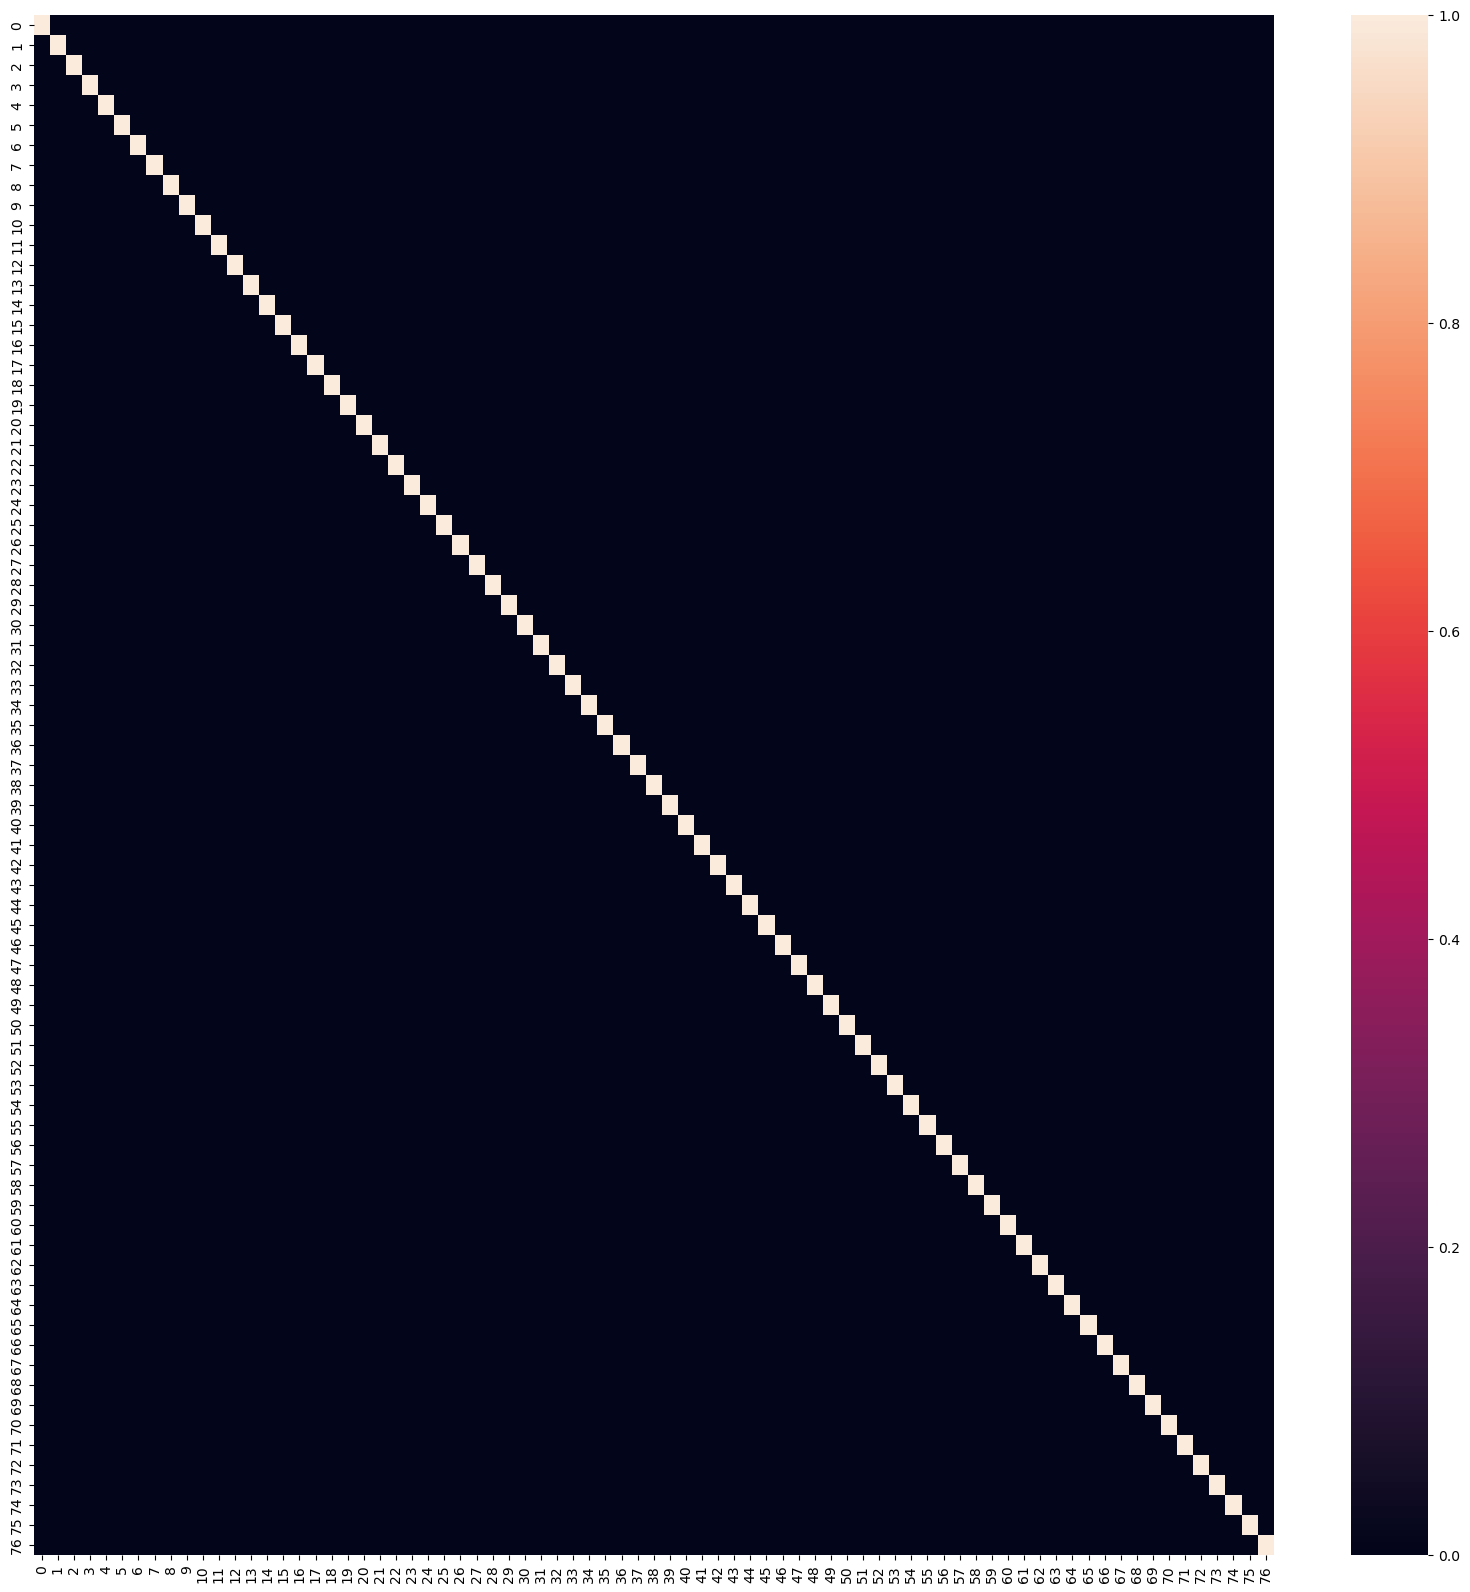

In [114]:
corrmat_95 = np.corrcoef(pca_transformed_train_data_95.transpose())
plt.figure(figsize=[20,20])
sns.heatmap(corrmat_95)

We can clearly notice that there is no correlation b/w the selected variables. Therefore, we can go ahead with this selection.

### Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
y_train.head()

20891    0
9146     1
16515    0
3077     0
233      1
Name: churn_probability, dtype: int64

#### Base Model

In [117]:
logreg_pca_95 = LogisticRegression(class_weight='balanced', random_state=10)
logreg_pca_95_model = logreg_pca_95.fit(pca_transformed_train_data_95, y_train)

##### Training Data Metrics

In [118]:
train_pred_logreg_pca_95_model = np.round(logreg_pca_95_model.predict_proba(pca_transformed_train_data_95), 2)
train_logreg_pca_95_model_pred_table = get_prediction_table( y_train,  train_pred_logreg_pca_95_model[:,1])

Shape of Prediction Table:  (21021, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
20891         0         0.25          0
9146          1         0.78          1
16515         0         0.31          0
3077          0         0.05          0
233           1         0.82          1


In [119]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(train_logreg_pca_95_model_pred_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Logistic (Base - 0.5 cut-off)', 'Training Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0  PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   

   False Negative %   AUC  Precision  Recall  Specificity  
0               1.6  0.82        0.3    0.82         0.82

##### Test Data Metrics

In [120]:
test_pred_logreg_pca_95_model = np.round(logreg_pca_95_model.predict_proba(pca_transformed_test_data_95),2)
test_logreg_pca_95_model_pred_table = get_prediction_table( y_test,  test_pred_logreg_pca_95_model[:,1])

Shape of Prediction Table:  (7008, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
2524          1         0.78          1
396           0         0.25          0
16724         0         0.02          0
6379          0         0.17          0
4380          1         0.60          1


In [122]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(test_logreg_pca_95_model_pred_table, 'Actual_y', 'Predicted')

# Creating metrics list
metric_row = [ 'PCA Logistic (Base - 0.5 cut-off)', 'Test Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Confusion Matrix: 
 [[5182 1232]
 [  87  507]]
Precision Score:  0.29
Recall Score:  0.85
Specificity:  0.81
False Negative %: 1.24 (87)
Accuracy:  0.81
Auc Score:  0.83


Model           Data  Accuracy  \
0  PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1  PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81

In [129]:
# Dropping last row in the dataframe

metrics_df.drop(metrics_df.index[-1], inplace=True)
metrics_df

Model           Data  Accuracy  \
0  PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1  PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81

#### Tunning

In [123]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1,0.5,1,2,3,4,5,10,100]}

In [124]:
# GridSearchCV
folds = 5

cv_model = GridSearchCV(
            estimator = logreg_pca_95_model,
            param_grid = params,
            scoring = 'recall',
            cv = folds,
            return_train_score = True,
            n_jobs = -1,
            verbose = 1)

cv_model.fit(pca_transformed_train_data_95, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=10),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10, 100],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='recall', verbose=1)

In [125]:
cv_model.best_params_

{'C': 1, 'penalty': 'l2'}

Since, these are the default values of logistic regression which we have already have in our base model, therefore, we don't need to build a tunned model. We already have the best version as our base model.

### Decision Tree

#### Base Model

In [130]:
from sklearn.tree import DecisionTreeClassifier

In [131]:
dt_pca_95 = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_pca_95_model = dt_pca_95.fit(pca_transformed_train_data_95, y_train)

##### Training Data Metrics

In [132]:
train_pred_dt_pca_95_model = np.round(dt_pca_95_model.predict_proba(pca_transformed_train_data_95), 2)
train_pred_dt_pca_95_model_table = get_prediction_table( y_train,  train_pred_dt_pca_95_model[:,1])

Shape of Prediction Table:  (21021, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
20891         0          0.0          0
9146          1          1.0          1
16515         0          0.0          0
3077          0          0.0          0
233           1          1.0          1


In [133]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(train_pred_dt_pca_95_model_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Decision Tree (Base - 0.5 cut-off)', 'Training Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0       PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1       PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2  PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00

##### Test Data Metrics

In [134]:
test_pred_dt_pca_95_model = np.round(dt_pca_95_model.predict_proba(pca_transformed_test_data_95),2)
test_pred_dt_pca_95_model_table = get_prediction_table(y_test,  test_pred_dt_pca_95_model[:,1])

Shape of Prediction Table:  (7008, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
2524          1          1.0          1
396           0          0.0          0
16724         0          0.0          0
6379          0          0.0          0
4380          1          0.0          0


In [135]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(test_pred_dt_pca_95_model_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Decision Tree (Base - 0.5 cut-off)', 'Test Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0       PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1       PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2  PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3  PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94

We can clearly see the overfitting. Therefore, as a 1st solution, we can try tunning the model so that our model doesn't overfit.

#### Model Tunning

##### Model 1

In [136]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,20,30],
    'min_samples_split': [100,200,300],
    'min_samples_leaf': [100,200,300]}

In [138]:
# GridSearchCV
folds = 5

cv_model = GridSearchCV(
            estimator = dt_pca_95_model,
            param_grid = params,
            scoring = 'recall',
            cv = folds,
            return_train_score = True,
            n_jobs = -1,
            verbose = 1)

cv_model.fit(pca_transformed_train_data_95, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [100, 200, 300],
                         'min_samples_split': [100, 200, 300]},
             return_train_score=True, scoring='recall', verbose=1)

In [139]:
cv_model.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 200,
 'min_samples_split': 100}

In [141]:
temp_tunned_dt_pca_95_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf = 200,
    min_samples_split= 100,
    class_weight='balanced',
    random_state=42)

temp_tunned_dt_pca_95_model.fit(pca_transformed_train_data_95, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=200,
                       min_samples_split=100, random_state=42)

##### Model 2

In [142]:
import time

In [144]:
params_2 = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [150,200,250],
    'min_samples_leaf': [50,100,150]}

In [145]:
start_time = time.time()

# GridSearchCV
folds = 5

cv_model_2 = GridSearchCV(
            estimator = temp_tunned_dt_pca_95_model,
            param_grid = params_2,
            scoring = 'recall',
            cv = folds,
            return_train_score = True,
            n_jobs = -1,
            verbose = 1)

cv_model_2.fit(pca_transformed_train_data_95, y_train)

end_time = time.time()

time_taken = end_time - start_time
print(f"Time Taken: {time_taken} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Time Taken: 347.46906661987305 seconds


In [146]:
cv_model_2.best_params_

{'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 150}

In [147]:
temp_2_tunned_dt_pca_95_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=15,
    min_samples_leaf = 100,
    min_samples_split= 150,
    class_weight='balanced',
    random_state=42)

temp_2_tunned_dt_pca_95_model.fit(pca_transformed_train_data_95, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=100,
                       min_samples_split=150, random_state=42)

##### Model 3

In [148]:
params_3 = {
    'max_depth': [13, 15, 17],
    'min_samples_split': [125, 150, 175],
    'min_samples_leaf': [75, 100, 125]}

In [149]:
start_time = time.time()

# GridSearchCV
folds = 5

cv_model_3 = GridSearchCV(
            estimator = temp_2_tunned_dt_pca_95_model,
            param_grid = params_3,
            scoring = 'recall',
            cv = folds,
            return_train_score = True,
            n_jobs = -1,
            verbose = 1)

cv_model_3.fit(pca_transformed_train_data_95, y_train)

end_time = time.time()

time_taken = end_time - start_time
print(f"Time Taken: {time_taken} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Time Taken: 409.06405544281006 seconds


In [150]:
cv_model_3.best_params_

{'max_depth': 13, 'min_samples_leaf': 100, 'min_samples_split': 125}

Let's consider these hyper-parameters for our final model

#### DT Final Model

In [151]:
tunned_dt_pca_95_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=13,
    min_samples_leaf = 100,
    min_samples_split= 125,
    class_weight='balanced',
    random_state=42)

tunned_dt_pca_95_model.fit(pca_transformed_train_data_95, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, min_samples_leaf=100,
                       min_samples_split=125, random_state=42)

##### Training Data Metrics

In [152]:
train_pred_tunned_dt_pca_95_model = np.round(tunned_dt_pca_95_model.predict_proba(pca_transformed_train_data_95), 2)
train_pred_tunned_dt_pca_95_model_table = get_prediction_table( y_train,  train_pred_tunned_dt_pca_95_model[:,1])

Shape of Prediction Table:  (21021, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
20891         0         0.00          0
9146          1         0.79          1
16515         0         0.00          0
3077          0         0.00          0
233           1         0.72          1


In [153]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(train_pred_tunned_dt_pca_95_model_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Decision Tree (Tunned - 0.5 cut-off)', 'Training Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0         PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1         PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2    PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3    PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4  PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94  
4              1.12  0.84       0.29    0.87         0.80

##### Test Data Metrics

In [154]:
test_pred_tunned_dt_pca_95_model = np.round(tunned_dt_pca_95_model.predict_proba(pca_transformed_test_data_95),2)
test_pred_tunned_dt_pca_95_model_table = get_prediction_table(y_test,  test_pred_tunned_dt_pca_95_model[:,1])

Shape of Prediction Table:  (7008, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
2524          1         0.71          1
396           0         0.00          0
16724         0         0.00          0
6379          0         0.39          0
4380          1         0.36          0


In [155]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(test_pred_tunned_dt_pca_95_model_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Decision Tree (Tunned - 0.5 cut-off)', 'Test Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0         PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1         PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2    PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3    PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4  PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   
5  PCA Decision Tree (Tunned - 0.5 cut-off)      Test Data      0.78   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94  
4              1.12  0.84       0.29    0.87         0.80  
5              1.61  0.80       0.25    0.81         0.78

### Random Forest

In [156]:
from sklearn.ensemble import RandomForestClassifier

#### Base Model

In [157]:
rf_pca_95_model = RandomForestClassifier(class_weight='balanced', random_state=100, oob_score=True)

In [158]:
rf_pca_95_model.fit(pca_transformed_train_data_95, y_train)

RandomForestClassifier(class_weight='balanced', oob_score=True,
                       random_state=100)

In [ ]:
rf_pca_95_model.oob_score_

##### Training Metrics

In [159]:
train_pred_rf_pca_95_model = rf_pca_95_model.predict_proba(pca_transformed_train_data_95)
train_pred_rf_pca_95_model_table = get_prediction_table( y_train,  train_pred_rf_pca_95_model[:,1])

Shape of Prediction Table:  (21021, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
20891         0         0.00          0
9146          1         0.76          1
16515         0         0.00          0
3077          0         0.00          0
233           1         0.67          1


In [160]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(train_pred_rf_pca_95_model_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Random Forest (Base - 0.5 cut-off)', 'Training Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0         PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1         PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2    PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3    PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4  PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   
5  PCA Decision Tree (Tunned - 0.5 cut-off)      Test Data      0.78   
6    PCA Random Forest (Base - 0.5 cut-off)  Training Data      1.00   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94  
4              1.12  0.84       0.29    0.87         0.80  
5              1.61  0.80       0.25    0.81         0.78  
6              0.01  1.00       1.00    1.00         1.00

##### Test Metrics

In [162]:
test_pred_rf_pca_95_model = rf_pca_95_model.predict_proba(pca_transformed_test_data_95)
test_pred_rf_pca_95_model_table = get_prediction_table(y_test,  test_pred_rf_pca_95_model[:,1])

Shape of Prediction Table:  (7008, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
2524          1         0.71          1
396           0         0.09          0
16724         0         0.06          0
6379          0         0.03          0
4380          1         0.07          0


In [163]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(test_pred_rf_pca_95_model_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Random Forest (Base - 0.5 cut-off)', 'Test Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0         PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1         PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2    PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3    PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4  PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   
5  PCA Decision Tree (Tunned - 0.5 cut-off)      Test Data      0.78   
6    PCA Random Forest (Base - 0.5 cut-off)  Training Data      1.00   
7    PCA Random Forest (Base - 0.5 cut-off)      Test Data      0.92   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94  
4              1.12  0.84       0.29    0.87         0.80  
5              1.61  0.80       0.25    0.81         0.78  
6              0.01  1.00       1.00    1.00         1.00  
7              6.99  0.58       0.67    0.18         0.99

Again, we can clearly see the overfitting. Therefore, as a 1st solution, we can try tunning the model so that our model doesn't overfit.

#### Model Tunning

In [165]:
params = {
    'n_estimators' : [10,50,100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,20,30],
    'min_samples_split': [100,200,300],
    'min_samples_leaf': [100,200,300]
    }

In [166]:
start_time = time.time()

# GridSearchCV
folds = 5

rf_cv_model = GridSearchCV(
            estimator = rf_pca_95_model,
            param_grid = params,
            scoring = 'recall',
            cv = folds,
            return_train_score = True,
            n_jobs = -1,
            verbose = 2)

rf_cv_model.fit(pca_transformed_train_data_95, y_train)

end_time = time.time()
total_time_taken = end_time - start_time

print(f'Total Time Taken: {total_time_taken} seconds')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [ ]:
rf_cv_model.best_params_

In [167]:
tunned_rf_pca_95_model_1 = RandomForestClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=300,
    min_samples_split=100,
    n_estimators = 50,
    class_weight='balanced',
    random_state=100,
    oob_score=True)

In [169]:
start_time = time.time()

tunned_rf_pca_95_model_1.fit(pca_transformed_train_data_95, y_train)

end_time = time.time()

total_time = end_time - start_time

print(f'Total {total_time} seconds taken')

Total 17.829583644866943 seconds taken


##### Training Metrics

In [170]:
train_pred_tunned_rf_pca_95_model_1 = tunned_rf_pca_95_model_1.predict_proba(pca_transformed_train_data_95)
train_pred_tunned_rf_pca_95_model_1_table = get_prediction_table( y_train,  train_pred_tunned_rf_pca_95_model_1[:,1])

Shape of Prediction Table:  (21021, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
20891         0     0.337009          0
9146          1     0.764653          1
16515         0     0.301015          0
3077          0     0.210294          0
233           1     0.675669          1


In [171]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(train_pred_tunned_rf_pca_95_model_1_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Random Forest (Tunned - 0.5 cut-off)', 'Training Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0         PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1         PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2    PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3    PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4  PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   
5  PCA Decision Tree (Tunned - 0.5 cut-off)      Test Data      0.78   
6    PCA Random Forest (Base - 0.5 cut-off)  Training Data      1.00   
7    PCA Random Forest (Base - 0.5 cut-off)      Test Data      0.92   
8  PCA Random Forest (Tunned - 0.5 cut-off)  Training Data      0.86   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94  
4              1.12  0.84       0.29    0.87         0.80  
5              1.61  0.80       0.25    0.81         0.78  
6              0.01  1.00       1.00    1.00         1.00  
7              6.99  0.58       0.67    0.18         0.99  
8              1.91  0.82       0.36    0.78         0.87

##### Test Metrics

In [172]:
test_pred_tunned_rf_pca_95_model_1 = tunned_rf_pca_95_model_1.predict_proba(pca_transformed_test_data_95)
test_pred_tunned_rf_pca_95_model_1_table = get_prediction_table( y_test,  test_pred_tunned_rf_pca_95_model_1[:,1])

Shape of Prediction Table:  (7008, 3)
Glance of the Prediction Table: 
        Actual_y  Pred_y_prob  Predicted
2524          1     0.803385          1
396           0     0.338503          0
16724         0     0.256089          0
6379          0     0.330787          0
4380          1     0.476737          0


In [173]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(test_pred_tunned_rf_pca_95_model_1_table, 'Actual_y', 'Predicted', Print=False)

# Creating metrics list
metric_row = [ 'PCA Random Forest (Tunned - 0.5 cut-off)', 'Test Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Model           Data  Accuracy  \
0         PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1         PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2    PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3    PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4  PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   
5  PCA Decision Tree (Tunned - 0.5 cut-off)      Test Data      0.78   
6    PCA Random Forest (Base - 0.5 cut-off)  Training Data      1.00   
7    PCA Random Forest (Base - 0.5 cut-off)      Test Data      0.92   
8  PCA Random Forest (Tunned - 0.5 cut-off)  Training Data      0.86   
9  PCA Random Forest (Tunned - 0.5 cut-off)      Test Data      0.85   

   False Negative %   AUC  Precision  Recall  Specificity  
0              1.60  0.82       0.30    0.82         0.82  
1              1.24  0.83       0.29    0.85         0.81  
2              0.00  1.00       1.00    1.00         1.00  
3              5.31  0.66       0.37    0.37         0.94  
4              1.12  0.84       0.29    0.87         0.80  
5              1.61  0.80       0.25    0.81         0.78  
6              0.01  1.00       1.00    1.00         1.00  
7              6.99  0.58       0.67    0.18         0.99  
8              1.91  0.82       0.36    0.78         0.87  
9              1.48  0.84       0.35    0.82         0.86

On comparing the models, you can see that performance of logistic model is comparable to random forest (RF). Since, logistic model is simpler as compare to RF, therefore, we 'll go with logistic model for this problem.

### Final Model

1. Feature Scaling
2. PCA - Fit Transform
3. Model Fit
4. Prepare Test Data
4. Making Prediction on Test data

#### Complete Data

In [174]:
final_data.shape

(28029, 169)

In [175]:
final_data.head()

arpu_6   arpu_7   arpu_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0  240.708  128.191  101.565           63.26           42.94           15.76   
1  167.861  167.869  167.866            0.00            0.00            0.00   
2  439.919  397.946  392.024          816.44          836.23          687.41   
3  580.549  377.294  338.286          327.64          366.79          391.53   
4  277.458  283.346  231.755          498.23          543.16          436.23   

   total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  total_rech_num_6  ...  \
0           21.54            9.36           28.31              13.0  ...   
1           25.11           15.89           43.83               2.0  ...   
2           34.49           35.34           26.99              15.0  ...   
3          233.18          777.39          629.94               5.0  ...   
4          238.29          545.58          565.38               6.0  ...   

   spl_ic_mou_diff  total_ic_mou_diff  total_rech_num_diff  \
0            0.000             12.860                 -3.5   
1            0.000             23.330                 -0.5   
2            0.000             -7.925                  7.5   
3            0.000            124.655                  0.0   
4           -0.175            173.445                 -2.5   

   total_rech_amt_diff  max_rech_amt_diff  total_rech_data_diff  \
0                -91.0              -15.5             -0.729422   
1                  0.0                0.0              0.000000   
2               -104.5              -60.0              0.000000   
3                125.0                0.0              0.500000   
4                -39.0              110.0              0.000000   

   max_rech_data_diff  av_rech_amt_data_diff  vol_2g_mb_diff  vol_3g_mb_diff  
0                -8.0                  -41.0        -136.375            0.00  
1                 0.0                    0.0         -81.510          106.66  
2                 0.0                    0.0           0.000            0.00  
3                77.0                   77.0         224.140            0.00  
4                 0.0                    0.0           0.000            0.00  

[5 rows x 169 columns]

#### Data Split

In [176]:
Final_X = final_data.drop(['churn_probability'],axis=1)
Final_y = final_data['churn_probability']

print(Final_X.shape)
print(Final_y.shape)

(28029, 168)
(28029,)


#### Feature Scaling

In [177]:
cols = Final_X.columns
final_scaled_training_data = scaler.fit_transform(Final_X)
final_scaled_training_data = pd.DataFrame(final_scaled_training_data, columns=cols)
final_scaled_training_data

arpu_6    arpu_7    arpu_8  total_og_mou_6  total_og_mou_7  \
0     -0.788672 -1.155220 -1.034562       -0.906368       -0.949153   
1     -1.029709 -1.024538 -0.830126       -1.033483       -1.033291   
2     -0.129518 -0.266765 -0.138949        0.607080        0.605243   
3      0.335801 -0.334784 -0.304647       -0.375120       -0.314592   
4     -0.667072 -0.644207 -0.633129       -0.032334        0.030993   
...         ...       ...       ...             ...             ...   
28024 -0.790723 -0.014923  0.810649       -0.548190        0.584826   
28025 -0.805825 -0.933096 -0.948124       -0.718388       -0.381859   
28026 -1.532984 -0.224022 -0.332860       -1.033483       -0.060081   
28027 -0.353959 -0.726454 -0.485040       -0.204239       -0.452535   
28028 -0.795729 -0.769139 -0.900441       -0.953549       -0.985618   

       total_og_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0           -0.915194       -0.920424       -0.985307       -0.866416   
1           -0.947293       -0.905997       -0.958938       -0.802852   
2            0.452773       -0.868090       -0.880398       -0.871823   
3           -0.149854       -0.065131        2.116054        1.597654   
4           -0.058812       -0.044480        1.179989        1.333238   
...               ...             ...             ...             ...   
28024        0.682251       -0.899329       -0.652852       -0.388371   
28025       -0.947293       -0.856411       -0.321973       -0.951442   
28026       -0.147715       -1.007473       -0.126692        0.121661   
28027       -0.250142        1.183619        0.659077        0.715449   
28028       -0.908025       -0.931376       -0.957525       -0.909625   

       total_rech_num_6  ...  spl_ic_mou_diff  total_ic_mou_diff  \
0              0.356364  ...         0.166619           0.168799   
1             -1.243570  ...         0.166619           0.241423   
2              0.647261  ...         0.166619           0.024626   
3             -0.807224  ...         0.166619           0.944253   
4             -0.661776  ...        -1.846588           1.282679   
...                 ...  ...              ...                ...   
28024          0.501813  ...        -2.421790           0.674774   
28025          1.229056  ...         0.166619          -0.599857   
28026         -1.389019  ...         0.166619           1.179466   
28027         -1.098121  ...         0.166619          -0.370159   
28028         -0.807224  ...         0.166619           0.081158   

       total_rech_num_diff  total_rech_amt_diff  max_rech_amt_diff  \
0                -0.385295            -0.096231          -0.095043   
1                 0.208405             0.196080           0.093444   
2                 1.791605            -0.139596          -0.636183   
3                 0.307355             0.597606           0.093444   
4                -0.187395             0.070803           1.431093   
...                    ...                  ...                ...   
28024             1.921175             1.426355          -0.636183   
28025            -0.484245            -0.097837           0.087364   
28026             1.098955             1.122802           0.701466   
28027             0.703155             0.064379           1.121002   
28028            -0.088445            -0.351602          -0.891552   

       total_rech_data_diff  max_rech_data_diff  av_rech_amt_data_diff  \
0                 -0.478683           -0.047086              -0.321509   
1                  0.046645            0.083557               0.090785   
2                  0.046645            0.083557               0.090785   
3                  0.406745            1.340998               0.865093   
4                  0.046645            0.083557               0.090785   
...                     ...                 ...                    ...   
28024              1.487043            0.312183               0.372351   
28025             -2.999379  

In [178]:
final_scaled_training_data.shape

(28029, 168)

#### PCA

In [180]:
final_pca_95 = PCA(0.95, random_state=10)
pca_transformed_final_scaled_training_data = final_pca_95.fit_transform(final_scaled_training_data)
pca_transformed_final_scaled_training_data.shape

(28029, 77)

#### Model Training

In [ ]:
# Doubt - Do I need to use the model object that we have created above or should I recreate the new one
# Why new? - Because we have a different training data here as compare to the above, so PCA might have created different components as compare to the previous one.
# Why old? Because it is already trained so we 'll have weights from previous training so our model 'll not have to start from scratch

In [181]:
# w/o using pre-trained model
final_logreg_pca_95_model = LogisticRegression(class_weight='balanced', random_state=10)
final_logreg_pca_95_model.fit(pca_transformed_final_scaled_training_data, Final_y)

LogisticRegression(class_weight='balanced', random_state=10)

In [182]:
final_logreg_pca_95_model_train_pred = np.round(final_logreg_pca_95_model.predict_proba(pca_transformed_final_scaled_training_data), 2)
final_logreg_pca_95_model_train_pred_table = get_prediction_table(y,  final_logreg_pca_95_model_train_pred[:,1])

Shape of Prediction Table:  (28029, 3)
Glance of the Prediction Table: 
    Actual_y  Pred_y_prob  Predicted
0         0         0.37          0
1         0         0.21          0
2         0         0.45          0
3         0         0.01          0
4         0         0.08          0


In [183]:
confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy, auc_score = get_evaluation_metrics(final_logreg_pca_95_model_train_pred_table, 'Actual_y', 'Predicted')

# Creating metrics list
metric_row = [ 'Final logreg Model (0.5 cut-off)', 'Training Data', accuracy, FN_perc, auc_score, precision, recall, specificity]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

Confusion Matrix: 
 [[20975  4620]
 [  426  2008]]
Precision Score:  0.3
Recall Score:  0.82
Specificity:  0.82
False Negative %: 1.52 (426)
Accuracy:  0.82
Auc Score:  0.82


Model           Data  Accuracy  \
0          PCA Logistic (Base - 0.5 cut-off)  Training Data      0.82   
1          PCA Logistic (Base - 0.5 cut-off)      Test Data      0.81   
2     PCA Decision Tree (Base - 0.5 cut-off)  Training Data      1.00   
3     PCA Decision Tree (Base - 0.5 cut-off)      Test Data      0.89   
4   PCA Decision Tree (Tunned - 0.5 cut-off)  Training Data      0.81   
5   PCA Decision Tree (Tunned - 0.5 cut-off)      Test Data      0.78   
6     PCA Random Forest (Base - 0.5 cut-off)  Training Data      1.00   
7     PCA Random Forest (Base - 0.5 cut-off)      Test Data      0.92   
8   PCA Random Forest (Tunned - 0.5 cut-off)  Training Data      0.86   
9   PCA Random Forest (Tunned - 0.5 cut-off)      Test Data      0.85   
10          Final logreg Model (0.5 cut-off)  Training Data      0.82   

    False Negative %   AUC  Precision  Recall  Specificity  
0               1.60  0.82       0.30    0.82         0.82  
1               1.24  0.83       0.29    0.85         0.81  
2               0.00  1.00       1.00    1.00         1.00  
3               5.31  0.66       0.37    0.37         0.94  
4               1.12  0.84       0.29    0.87         0.80  
5               1.61  0.80       0.25    0.81         0.78  
6               0.01  1.00       1.00    1.00         1.00  
7               6.99  0.58       0.67    0.18         0.99  
8               1.91  0.82       0.36    0.78         0.87  
9               1.48  0.84       0.35    0.82         0.86  
10              1.52  0.82       0.30    0.82         0.82

# Feature Importance

In [ ]:
# Doubt - We can't use old model for feature importance as it is trained on PCA transformed data which makes it impossible to predict the feature importance. Therefore, we need to create a new object with the tunned parameters and retrain the
#         model on complete dataset

In [ ]:
final_scaled_training_data

In [188]:
feature_imp_rf_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=300,
    min_samples_split=100,
    n_estimators = 50,
    class_weight='balanced',
    random_state=100,
    oob_score=True)
feature_imp_rf_model.fit(final_scaled_training_data, Final_y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=300,
                       min_samples_split=100, n_estimators=50, oob_score=True,
                       random_state=100)

In [189]:
feature_imp_rf_model.feature_importances_.sum()

1.0

In [199]:
rf_feature_importance_df = pd.DataFrame({'Feature': final_scaled_training_data.columns, 'Feature Importance': feature_imp_rf_model.feature_importances_*100})
#feature_importance_df
sorted_feature_imp_df = rf_feature_importance_df.sort_values(by='Feature Importance', ascending=False).reset_index(drop=True)
sorted_feature_imp_df

Feature  Feature Importance
0       roam_og_mou_8            9.190917
1      total_og_mou_8            9.146694
2      total_ic_mou_8            8.247352
3    total_rech_amt_8            6.597103
4              arpu_8            5.197342
..                ...                 ...
163     fb_user_6_0.0            0.000000
164  std_og_t2f_mou_6            0.000000
165      monthly_2g_7            0.000000
166     fb_user_8_0.0            0.000000
167      monthly_2g_6            0.000000

[168 rows x 2 columns]

In [209]:
top_10_features = sorted_feature_imp_df.iloc[:10,:]
top_20_features = sorted_feature_imp_df.iloc[:20,:]
top_30_features = sorted_feature_imp_df.iloc[:30,:]
top_40_features = sorted_feature_imp_df.iloc[:40,:]
top_50_features = sorted_feature_imp_df.iloc[:50,:]

In [211]:
top_10_features.sum()

Feature               roam_og_mou_8total_og_mou_8total_ic_mou_8total...
Feature Importance                                              58.5241
dtype: object

In [205]:
top_20_features.sum()

Feature               roam_og_mou_8total_og_mou_8total_ic_mou_8total...
Feature Importance                                            77.072453
dtype: object

In [207]:
top_30_features.sum()

Feature               roam_og_mou_8total_og_mou_8total_ic_mou_8total...
Feature Importance                                            85.547893
dtype: object

In [206]:
top_40_features.sum()

Feature               roam_og_mou_8total_og_mou_8total_ic_mou_8total...
Feature Importance                                            90.140809
dtype: object

In [210]:
top_50_features.sum()

Feature               roam_og_mou_8total_og_mou_8total_ic_mou_8total...
Feature Importance                                            93.058609
dtype: object

Going over 30 features doesn't give us an equivalent imporvement in feature importance. Therefore, we 'll try to analyse these 30 features.

In [213]:
top_30_features_cols = top_30_features['Feature']
top_30_features_cols

0            roam_og_mou_8
1           total_og_mou_8
2           total_ic_mou_8
3         total_rech_amt_8
4                   arpu_8
5       last_day_rch_amt_8
6           max_rech_amt_8
7            roam_ic_mou_8
8             loc_og_mou_8
9             loc_ic_mou_8
10               arpu_diff
11     total_rech_amt_diff
12        roam_og_mou_diff
13        roam_ic_mou_diff
14        loc_ic_t2m_mou_8
15       total_og_mou_diff
16        loc_og_t2m_mou_8
17         std_og_mou_diff
18    night_pck_user_8_0.0
19     total_rech_num_diff
20       total_ic_mou_diff
21        loc_og_t2t_mou_8
22      av_rech_amt_data_8
23         max_rech_data_8
24             vol_3g_mb_8
25        loc_ic_t2t_mou_8
26       max_rech_amt_diff
27       total_rech_data_8
28         loc_ic_mou_diff
29           roam_og_mou_7
Name: Feature, dtype: object

In [237]:
cols_to_analyse = top_30_features_cols.append(pd.Series([ "churn_probability"])).reset_index(drop=True)
cols_to_analyse

0            roam_og_mou_8
1           total_og_mou_8
2           total_ic_mou_8
3         total_rech_amt_8
4                   arpu_8
5       last_day_rch_amt_8
6           max_rech_amt_8
7            roam_ic_mou_8
8             loc_og_mou_8
9             loc_ic_mou_8
10               arpu_diff
11     total_rech_amt_diff
12        roam_og_mou_diff
13        roam_ic_mou_diff
14        loc_ic_t2m_mou_8
15       total_og_mou_diff
16        loc_og_t2m_mou_8
17         std_og_mou_diff
18    night_pck_user_8_0.0
19     total_rech_num_diff
20       total_ic_mou_diff
21        loc_og_t2t_mou_8
22      av_rech_amt_data_8
23         max_rech_data_8
24             vol_3g_mb_8
25        loc_ic_t2t_mou_8
26       max_rech_amt_diff
27       total_rech_data_8
28         loc_ic_mou_diff
29           roam_og_mou_7
30       churn_probability
dtype: object

# Recommendations

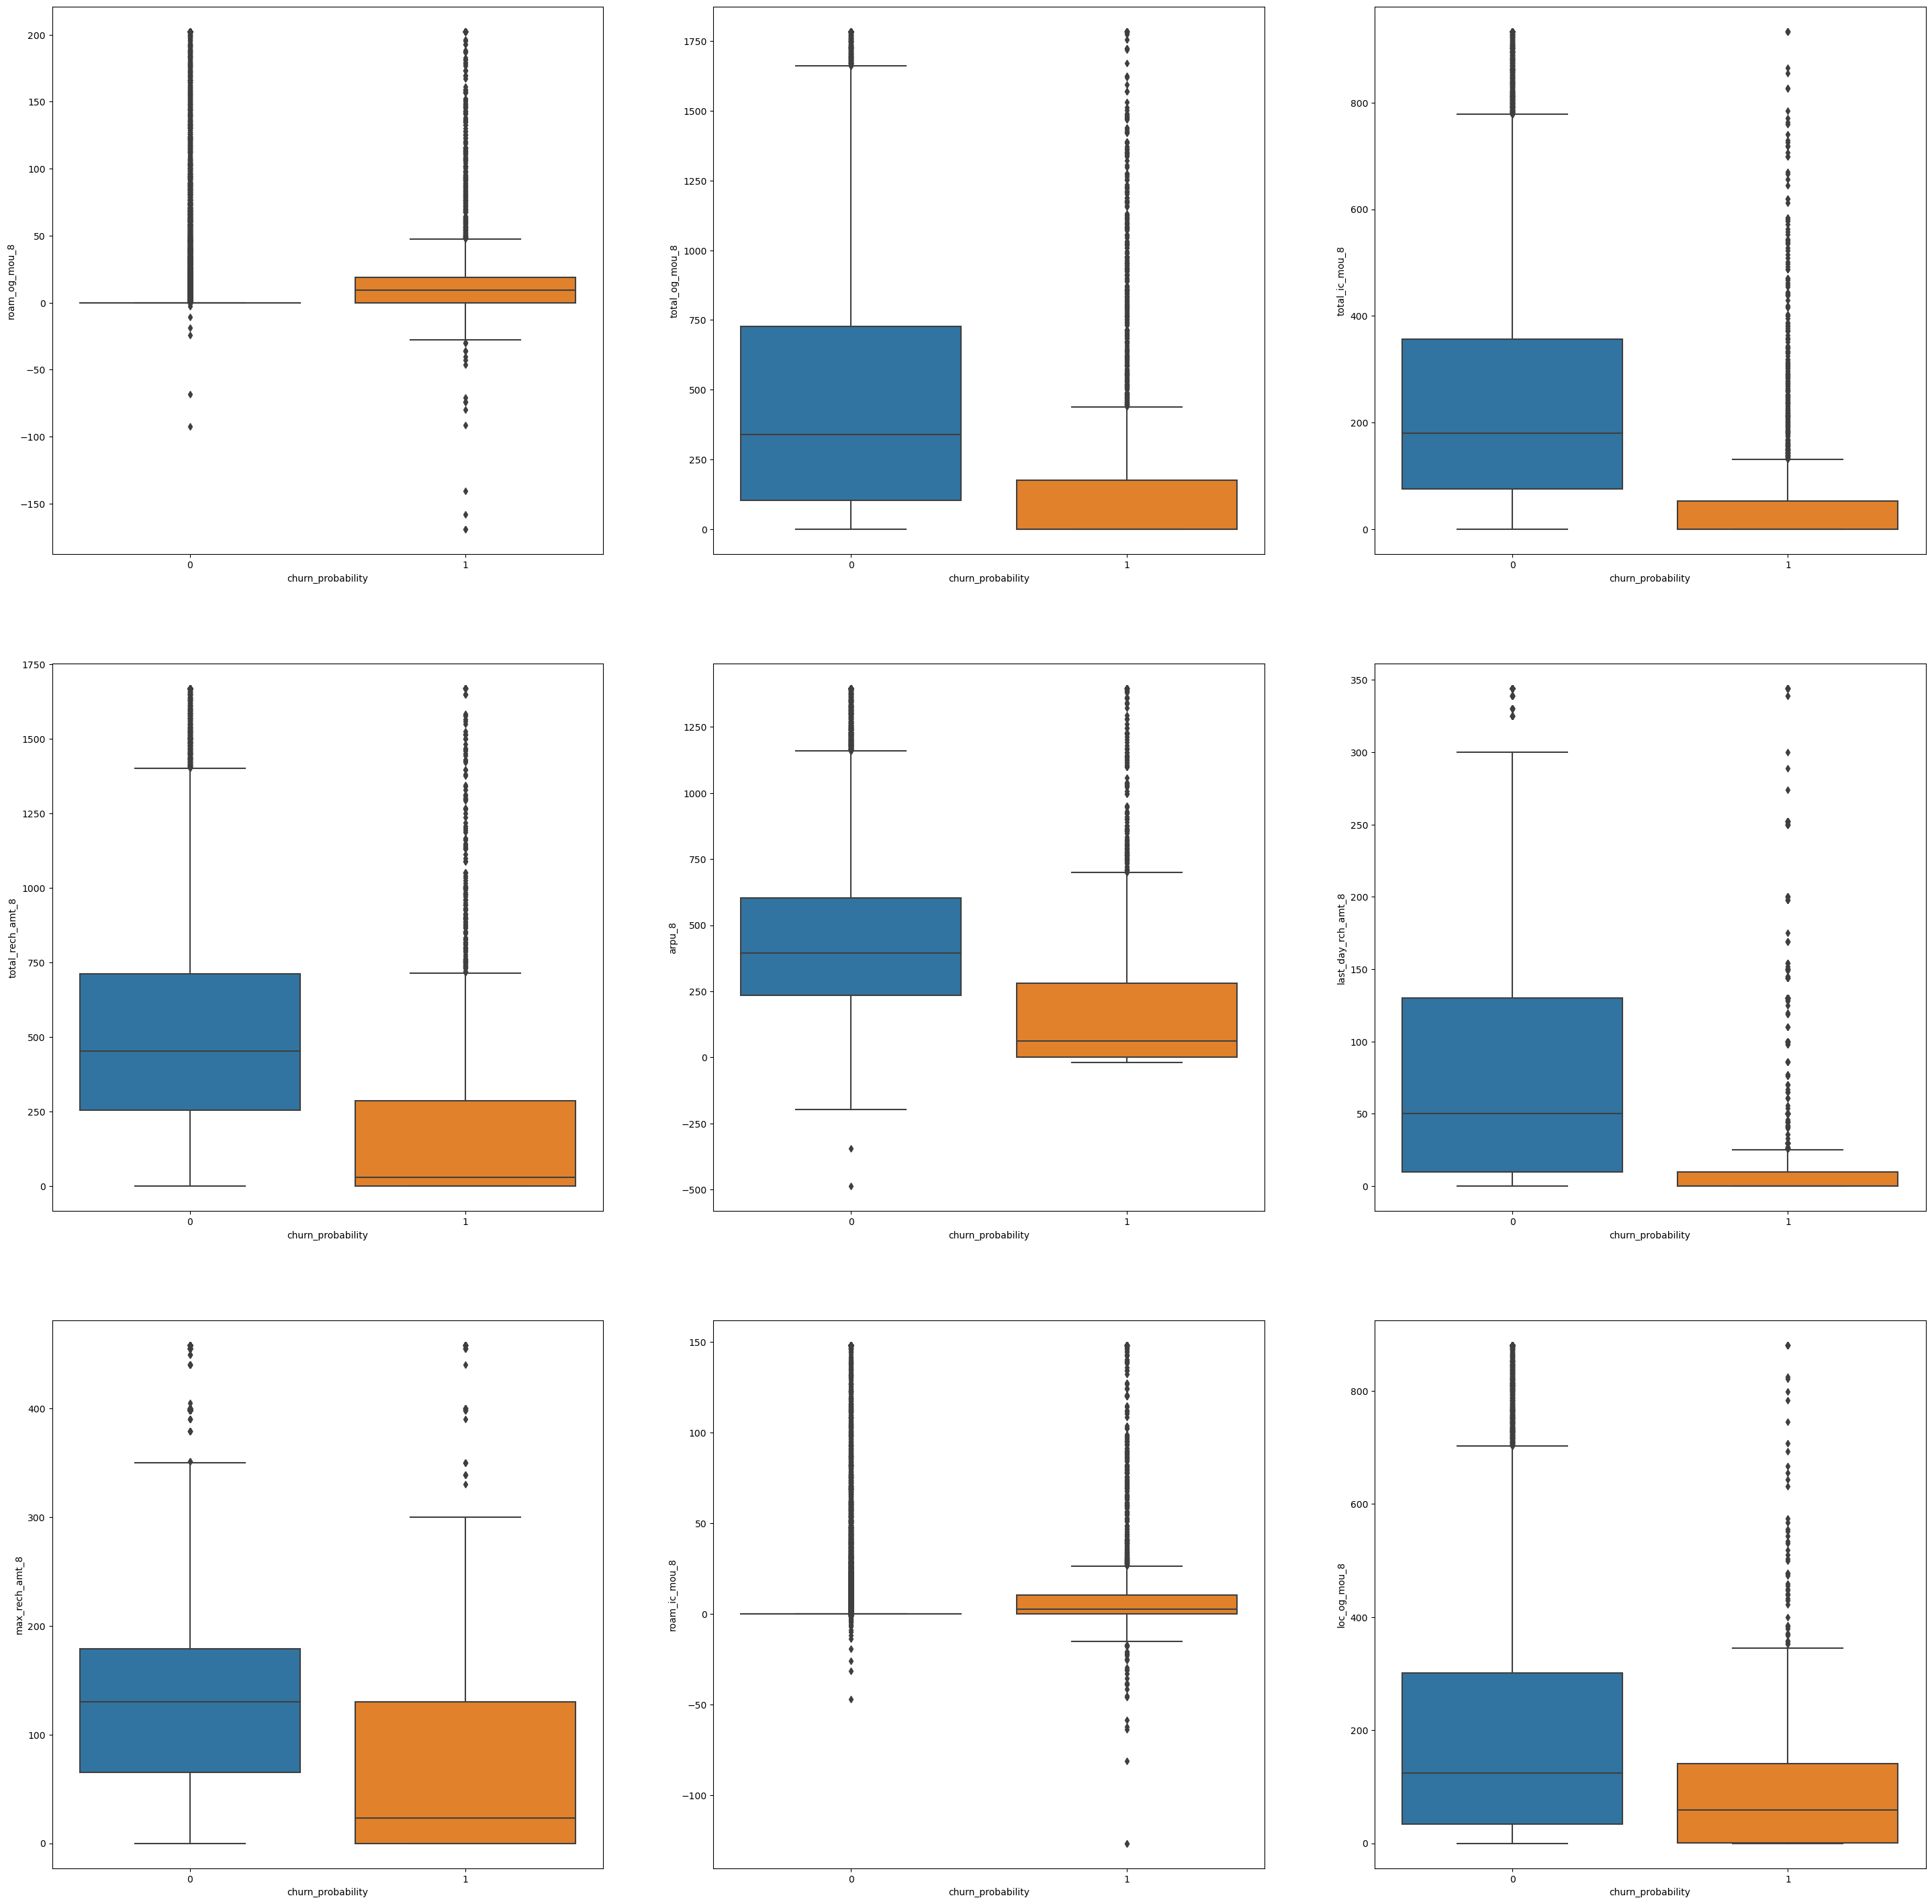

In [242]:
plt.figure(figsize=(36, 36))

for i in range(1,10):
    col = cols_to_analyse[i-1]
    plt.subplot(3,3,i)
    sns.boxplot(data= final_data, y = col, x = 'churn_probability')

1. Since, 'roam_og_mou_8' has the maximum importance, therefore, company should focus on packages related to roaming calling.
2. If total outgoing calls has reduced, then, customer 'll churn. Therefore, company should focus on calling plans.
3. If total incoming calls has reduced, then, there are high chances that customer is using some other network. Therefore, company should focus on packages & services that make a user use this number like higher speed, cheaper calling plans, etc.
4. If customers made a very small amount recharge, then, there are higher chances of churn. Therefore, company should focus on longer plans with attractive offer like cheaper yearly plans, OTT subscription on yearly recharge & so on.